In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

# For pretty printing pd tables
from pandas.api.types import is_numeric_dtype
from IPython.display import display, HTML


if __name__ == "__main__" and '__file__' not in globals():
    # Read definitions
    with open("file_mosquitos.txt", "r") as f:
        DATA_PATH = f.readline().split("=")[1].strip()
        SEP = f.readline().split("=")[1].strip()
        TARGET_COL = f.readline().split("=")[1].strip()
        train_name = f.readline().split("=")[1].strip()
        test_name = f.readline().split("=")[1].strip()
        try:
            skip_cols = f.readline().split("=")[1].strip()
        except:
            skip_cols = ""

    SPACE = "\n\n" + "---"*40 + "\n\n"

    # Any number less than this of nunique() will be considered as a categorical value
    #     encoded as numerical
    AMOUNT_TO_CONSIDER_CATEGORICAL = 50

In [2]:
if __name__ == "__main__" and '__file__' not in globals():
    train_df = pd.read_csv(f"{DATA_PATH}/{train_name}", sep=SEP)
    test_df = pd.read_csv(f"{DATA_PATH}/{test_name}", sep=SEP)

    merged_df = train_df.append(test_df, ignore_index=True, sort=False)
    
    TARGET_COLS =["level0", "level1", "level2", "level3"]
    TARGET_COL = "level0"
    merged_df[TARGET_COLS ] =  merged_df["class"].str.split(".",
                                                     expand=True).iloc[:, 1:]

In [3]:
def basic_describe(df, name="Train"):
    print(f"{name} shape: {df.shape} \n\n")
    print(f"Columns in {name}: ")
    print("\t", end="")
    print(*df.columns, sep="\n\t")
    print(SPACE)

    # NaNs
    nans = df.isna().sum()
    print(f"Amount of NaNs in total: {nans.sum()}")
    if nans.sum():
        print("NaNs per column:")
        display(HTML(pd.DataFrame(nans).to_html()))
    print(SPACE)

    # Basic Stats:
    print("Numerical Type stats:")
    display(HTML(df.describe().T.to_html()))
    print(SPACE)

    temp = df.select_dtypes(include="object")
    if len(temp.columns):
        print("Categorical Type stats:")
        display(HTML(temp.describe(include=['O']).T.to_html()))
        print(SPACE)

    for target_col in TARGET_COLS:
        print(f"Distribution of target: ")
        if df[target_col].dtype == "int64":
            temp = pd.DataFrame(df[target_col].value_counts(normalize=True))
            display(HTML(temp.to_html()))
            sns.countplot(df[target_col])
        elif df[target_col].dtype == "float64":
            sns.distplot(df[target_col], hist=False)
        else:
            sns.countplot(df[target_col])
            plt.xticks(rotation=90)
        plt.show()
        print(SPACE)


# Distplot
def my_distplot(df, col):
    if TARGET_COL:
        _, bins = np.histogram(df[col])
        g = sns.FacetGrid(df, hue=TARGET_COL, height=9)
        g.map(sns.distplot, col, bins=bins, hist=False)
        g.axes[0][0].legend()
    else:
        sns.distplot(df[col], hist=False)


def dist_columns(df):
    if TARGET_COL:
        cols = df.drop(columns=TARGET_COL).columns
    else:
        cols = df.columns

    for col in cols:
        nunique = df[col].nunique()
        if is_numeric_dtype(df[col]):
            print("\t\t", col)
            if nunique < AMOUNT_TO_CONSIDER_CATEGORICAL:
                if TARGET_COL:
                    sns.countplot(data=df, x=col, hue=TARGET_COL)
                else:
                    sns.countplot(data=df, x=col)
            else:
                my_distplot(df, col)
        else:
            print("\t\t", col)
            if nunique < 2*AMOUNT_TO_CONSIDER_CATEGORICAL:
                plt.figure(figsize=(16, 12))
                sns.countplot(data=df, x=col, hue=TARGET_COL)
                plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                plt.xticks(rotation=90)

        plt.show()
        print(SPACE)


def boxplot_columns(df):
    if TARGET_COL:
        cols = df.drop(columns=TARGET_COL).columns
    else:
        cols = df.columns

    for col in cols:
        if is_numeric_dtype(df[col]):
            print("\t\t", col)
            nunique = df[col].nunique()
            if TARGET_COL:
                sns.boxplot(data=df, y=col, x=TARGET_COL)
            else:
                sns.boxplot(df[col])
            plt.xticks(rotation=90)
            plt.show()
            print(SPACE)


def correlation(df):
    numeric_cols = [x for x in df.columns if is_numeric_dtype(df[x])]
    plt.figure(figsize=(20, 15))
    sns.heatmap(df[numeric_cols].corr("spearman"), annot=True)
    plt.show()
    print(SPACE)

In [4]:
# Outliers
def calculate_outliers(our_df):
    # Remove NaNs otherwise functions dont work
    print("Remove any NaNs for outlier detection!\n")
    df = our_df.dropna()
    
    iqr_threshold = [1.5, 2, 2.5]
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    # For different threshold
    for thres in iqr_threshold:
        try:
            outliers_idx = ((df < (Q1 - thres*IQR)) | (df > (Q3 + thres*IQR))).any(axis=1)
            amount =  outliers_idx.sum()
            print(f"Considering column {thres}*IQR: \t we have {amount} ",
                  f"({(100*amount)/len(df)}%) of outliers")
        except Exception as error:
            print("Error - could not process all cols for IQR analysis.", 
                  "Maybe differente types?")
            print(error)
    
    print(SPACE)
        
    # For different columns
    thres = 1.5
    print(f"Consdiering {thres}*IQR, we have....\n")
    for col in df.columns:
        try:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            outliers_idx = ((df[col] < (Q1 - thres*IQR)) | (df[col] > (Q3 + thres*IQR)))
            amount =  outliers_idx.sum()
            if amount != 0:
                print(f"Considering {col} \t we have {amount} ",
                      f"({(100*amount)/len(df)}%) of outliers\n")
        except:
            print(f"Error - could not process col {col}")
            


- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Basic Describe

<br>

Train shape: (21722, 38) 


Columns in Train: 
	peaks_freq_1
	peaks_freq_2
	peaks_freq_3
	peaks_freq_4
	peaks_freq_5
	peaks_freq_6
	inharmonicity
	eh_1
	eh_2
	eh_3
	eh_4
	eh_5
	eh_6
	eh_7
	eh_8
	eh_9
	eh_10
	eh_11
	eh_12
	eh_13
	eh_14
	eh_15
	eh_16
	eh_17
	eh_18
	eh_19
	eh_20
	eh_21
	eh_22
	eh_23
	eh_24
	eh_25
	eh_26
	class
	level0
	level1
	level2
	level3


------------------------------------------------------------------------------------------------------------------------


Amount of NaNs in total: 8020
NaNs per column:


,0
peaks_freq_1,0
peaks_freq_2,0
peaks_freq_3,0
peaks_freq_4,0
peaks_freq_5,0
peaks_freq_6,0
inharmonicity,0
eh_1,0
eh_2,0
eh_3,0




------------------------------------------------------------------------------------------------------------------------


Numerical Type stats:


,count,mean,std,min,25%,50%,75%,max
peaks_freq_1,21722.0,0.138482,0.087777,0.001164,0.076058,0.120880,0.180598,0.494692
peaks_freq_2,21722.0,0.098185,0.061006,0.000836,0.055921,0.083077,0.138858,0.583833
peaks_freq_3,21722.0,0.148017,0.099844,0.000143,0.076966,0.136960,0.217133,0.735070
peaks_freq_4,21722.0,0.179315,0.117448,0.000543,0.100033,0.167114,0.259382,0.981628
peaks_freq_5,21722.0,0.183427,0.126968,0.000104,0.096709,0.174060,0.270212,0.874960
peaks_freq_6,21722.0,0.170333,0.107854,0.000449,0.103638,0.157103,0.243169,0.658758
inharmonicity,21722.0,0.168316,0.091263,0.000076,0.087751,0.155443,0.225666,0.645971
eh_1,21722.0,0.043593,0.052834,0.000541,0.011169,0.027066,0.054721,0.817653
eh_2,21722.0,0.043027,0.043585,0.000746,0.015997,0.030817,0.054779,0.714195
eh_3,21722.0,0.051705,0.050047,0.000919,0.019813,0.037672,0.065898,0.712717




------------------------------------------------------------------------------------------------------------------------


Categorical Type stats:


,count,unique,top,freq
class,21722,14,Diptera.Drosophilidae.Drosophila.D-suzukii,2005
level0,21722,4,Culicidae,13702
level1,21722,6,Aedes,6020
level2,21722,9,Cx-quinquefasciatus,3010
level3,13702,10,Ae-albopictus:M,1505




------------------------------------------------------------------------------------------------------------------------


Distribution of target: 


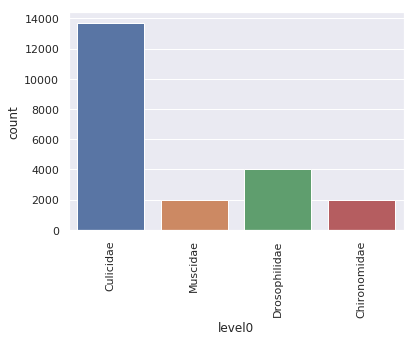



------------------------------------------------------------------------------------------------------------------------


Distribution of target: 


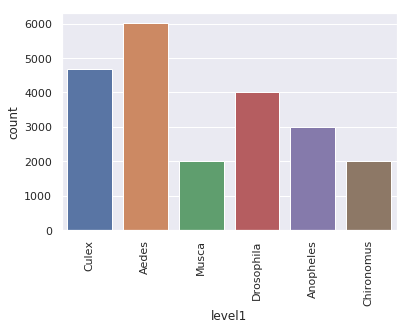



------------------------------------------------------------------------------------------------------------------------


Distribution of target: 


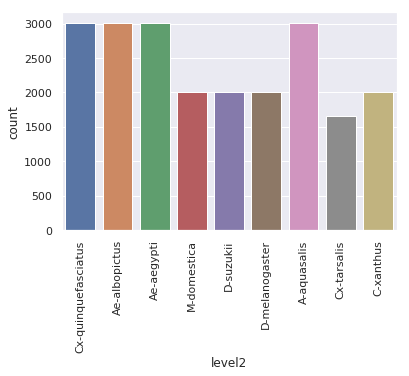



------------------------------------------------------------------------------------------------------------------------


Distribution of target: 


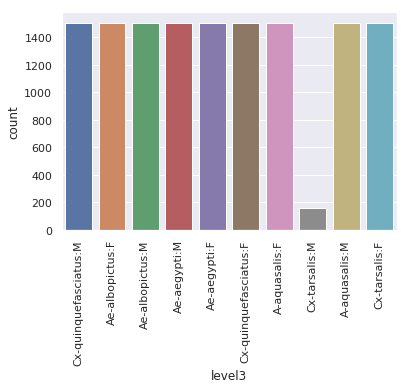



------------------------------------------------------------------------------------------------------------------------




In [5]:
if __name__ == "__main__" and '__file__' not in globals():
    basic_describe(merged_df, "Train")

- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Distplots

		 peaks_freq_1


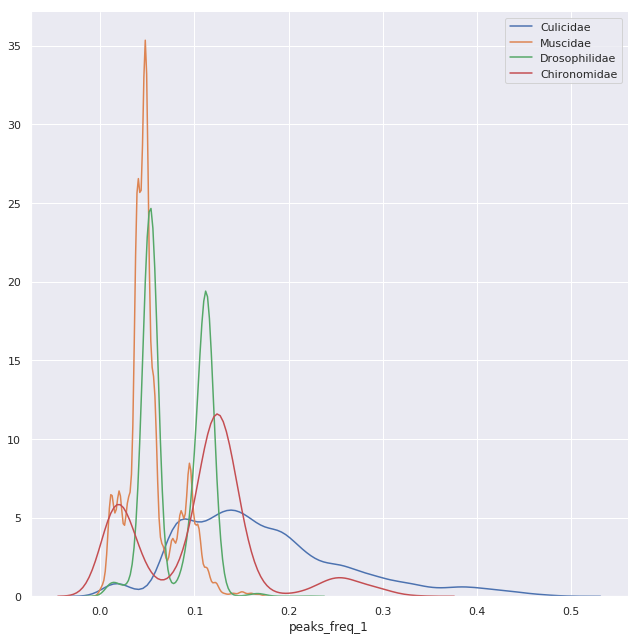



------------------------------------------------------------------------------------------------------------------------


		 peaks_freq_2


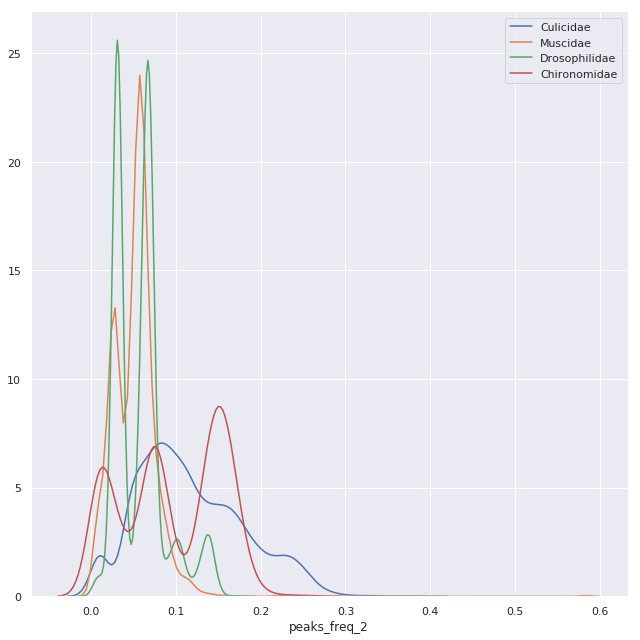



------------------------------------------------------------------------------------------------------------------------


		 peaks_freq_3


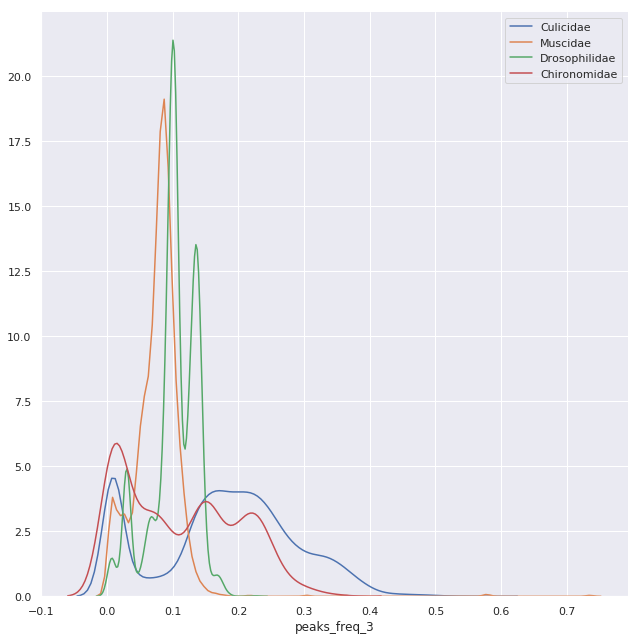



------------------------------------------------------------------------------------------------------------------------


		 peaks_freq_4


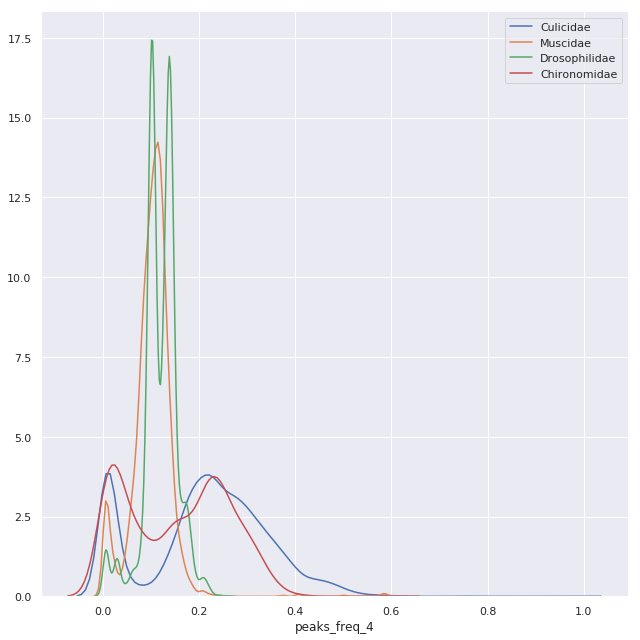



------------------------------------------------------------------------------------------------------------------------


		 peaks_freq_5


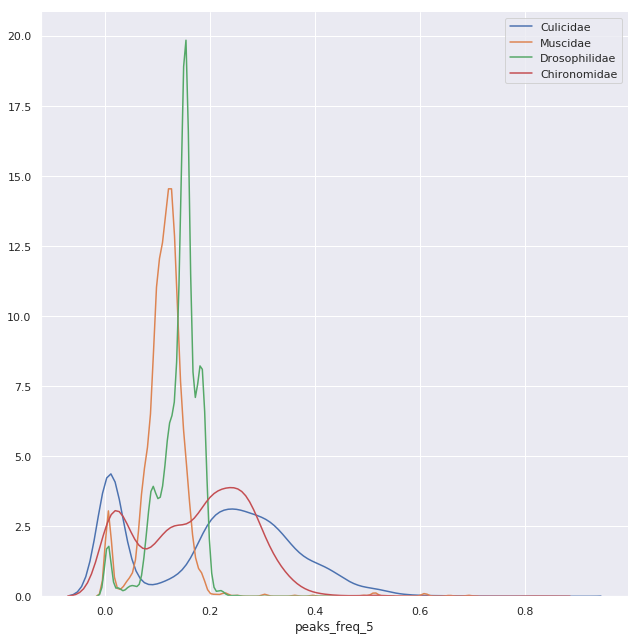



------------------------------------------------------------------------------------------------------------------------


		 peaks_freq_6


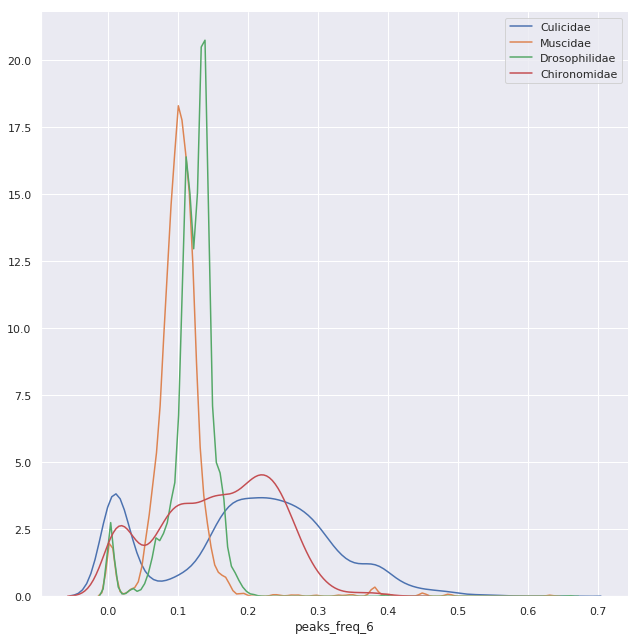



------------------------------------------------------------------------------------------------------------------------


		 inharmonicity


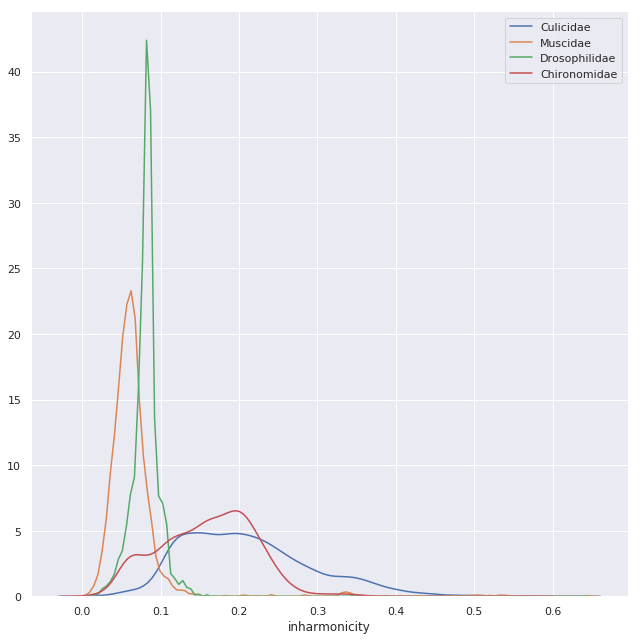



------------------------------------------------------------------------------------------------------------------------


		 eh_1


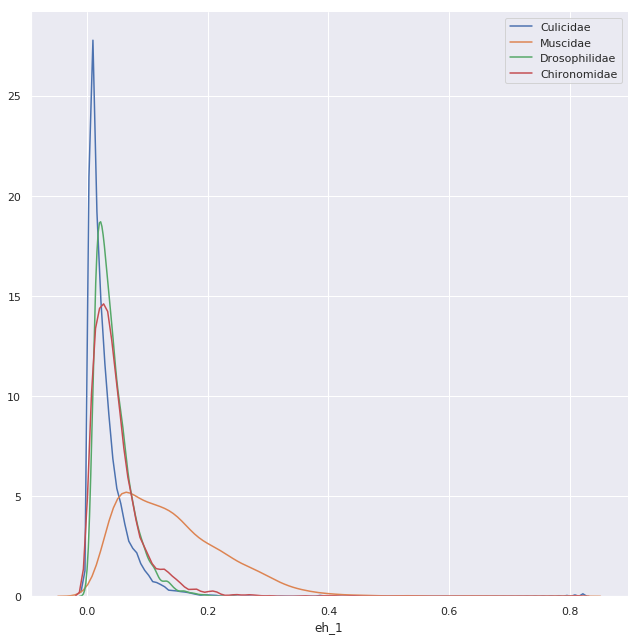



------------------------------------------------------------------------------------------------------------------------


		 eh_2


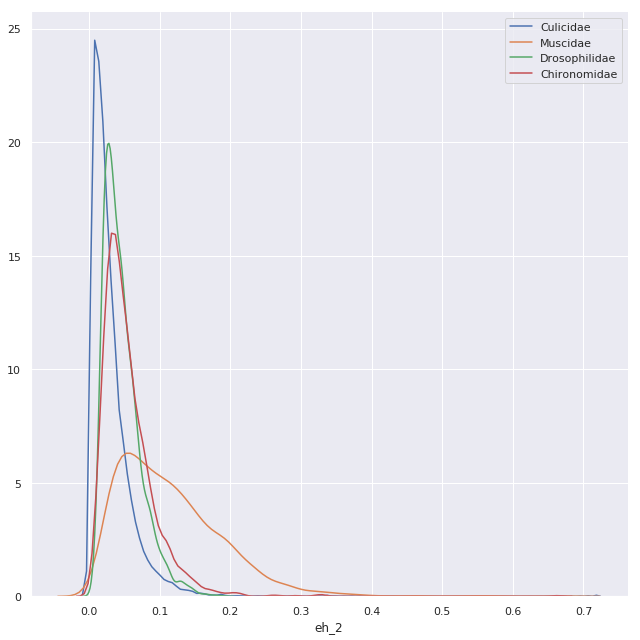



------------------------------------------------------------------------------------------------------------------------


		 eh_3


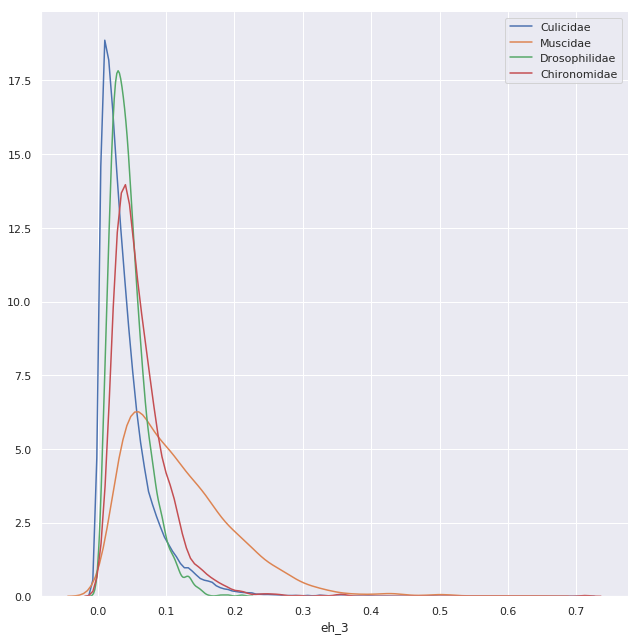



------------------------------------------------------------------------------------------------------------------------


		 eh_4


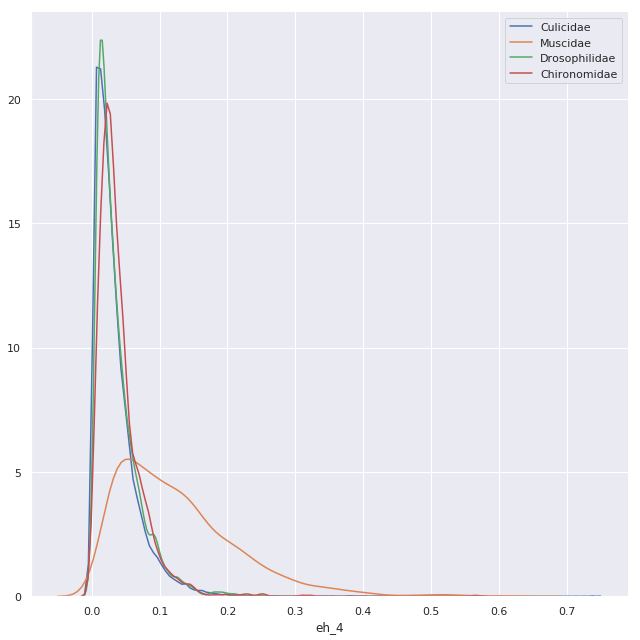



------------------------------------------------------------------------------------------------------------------------


		 eh_5


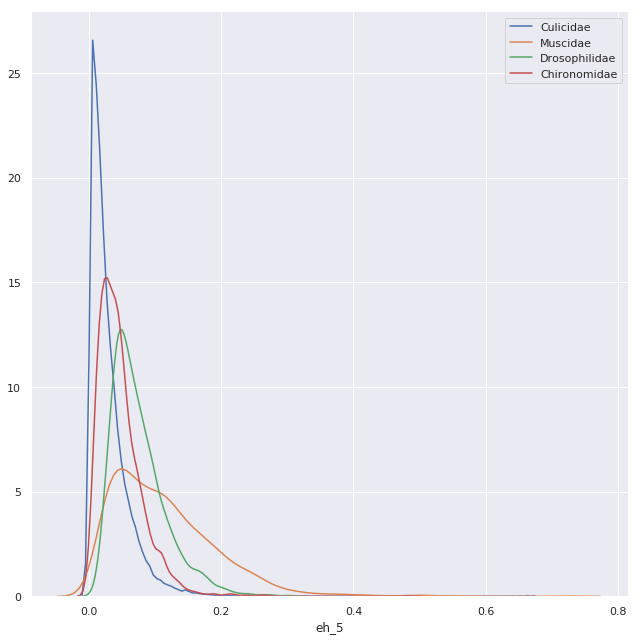



------------------------------------------------------------------------------------------------------------------------


		 eh_6


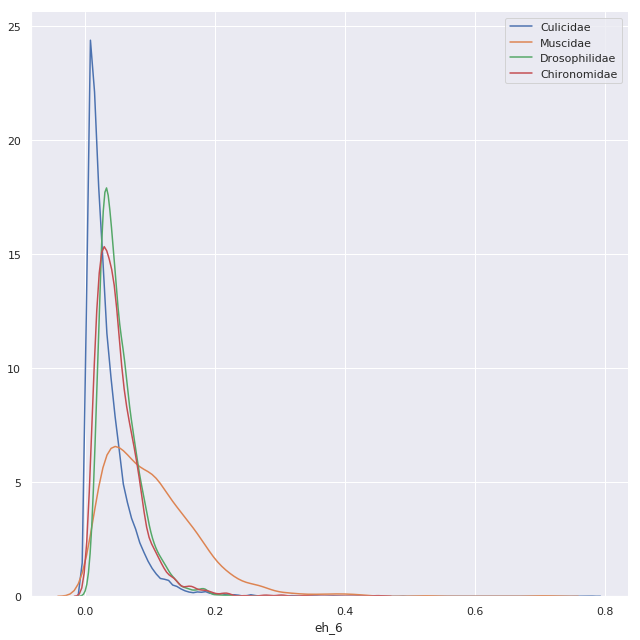



------------------------------------------------------------------------------------------------------------------------


		 eh_7


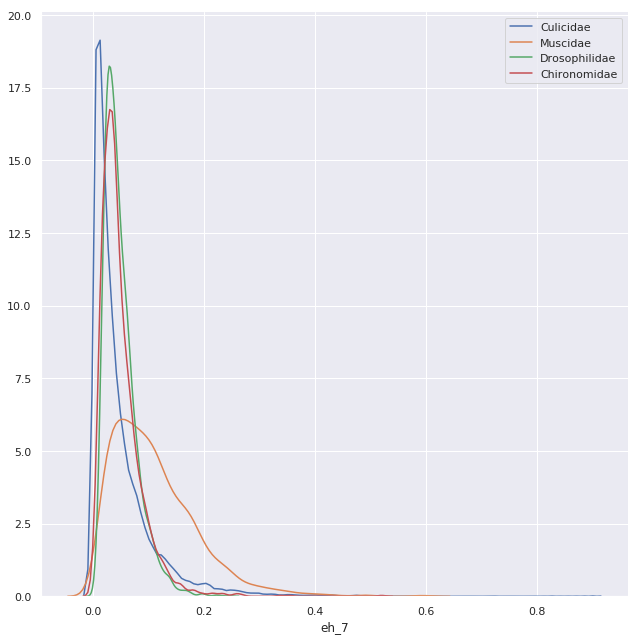



------------------------------------------------------------------------------------------------------------------------


		 eh_8


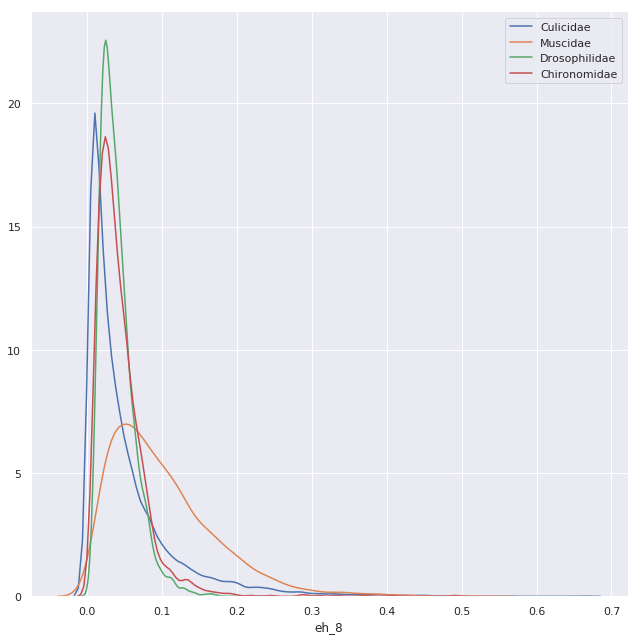



------------------------------------------------------------------------------------------------------------------------


		 eh_9


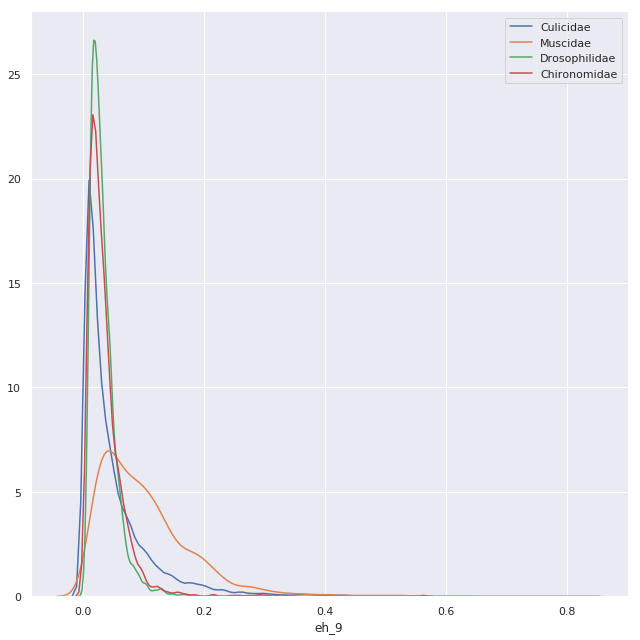



------------------------------------------------------------------------------------------------------------------------


		 eh_10


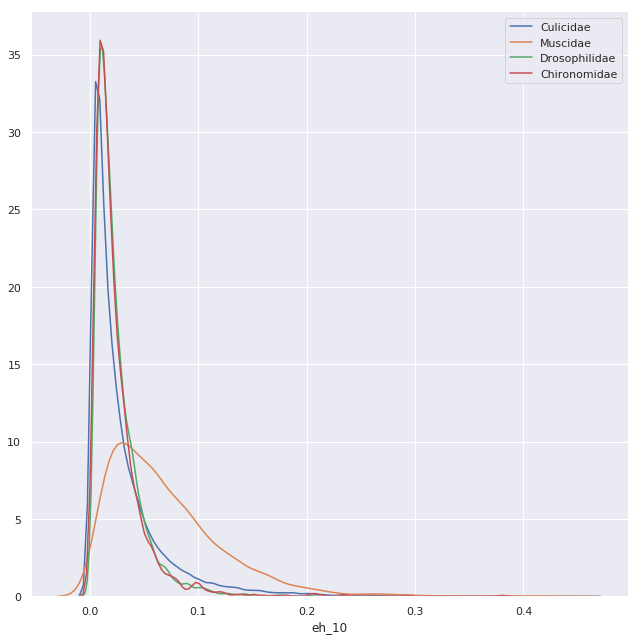



------------------------------------------------------------------------------------------------------------------------


		 eh_11


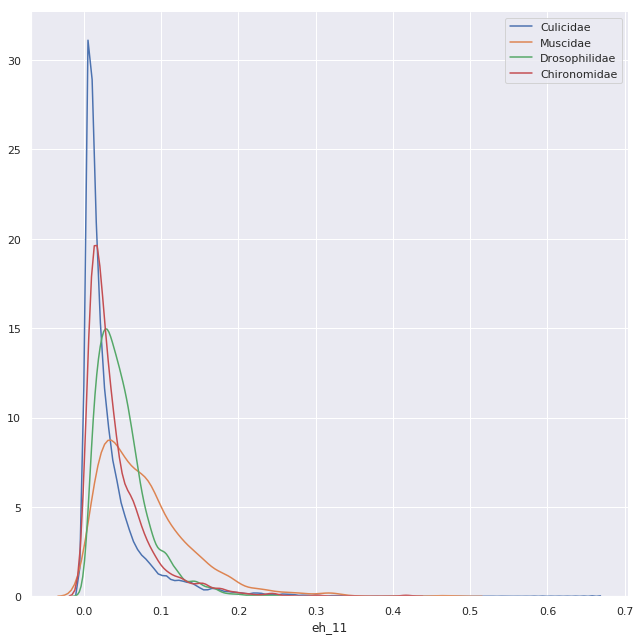



------------------------------------------------------------------------------------------------------------------------


		 eh_12


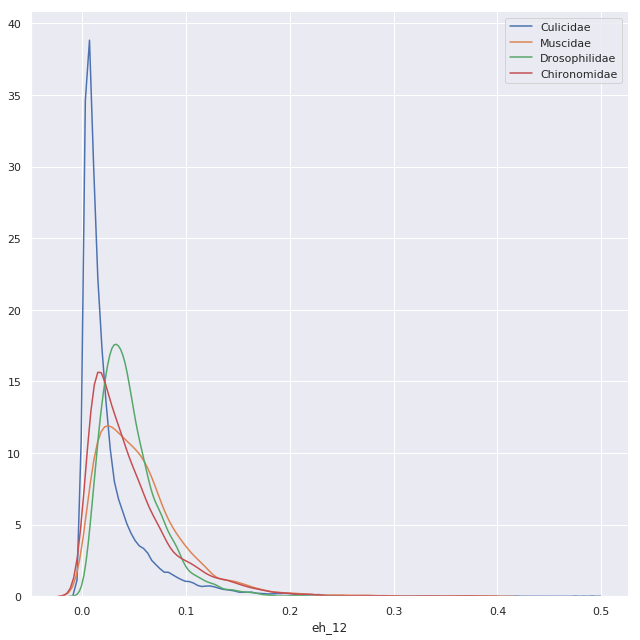



------------------------------------------------------------------------------------------------------------------------


		 eh_13


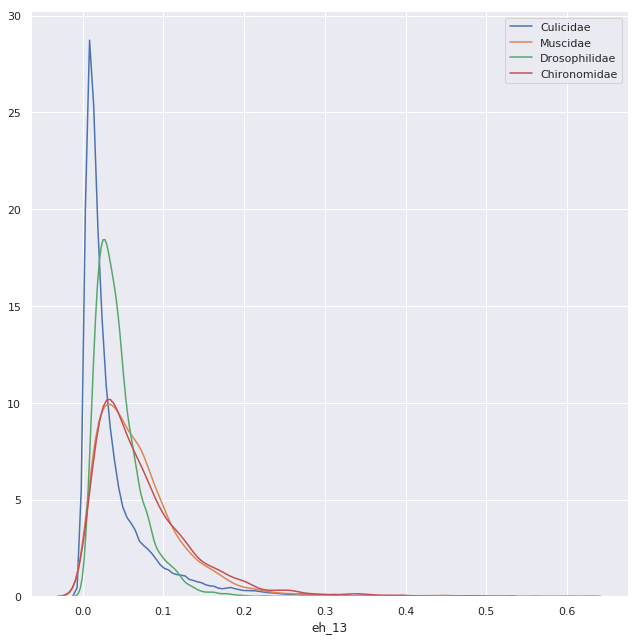



------------------------------------------------------------------------------------------------------------------------


		 eh_14


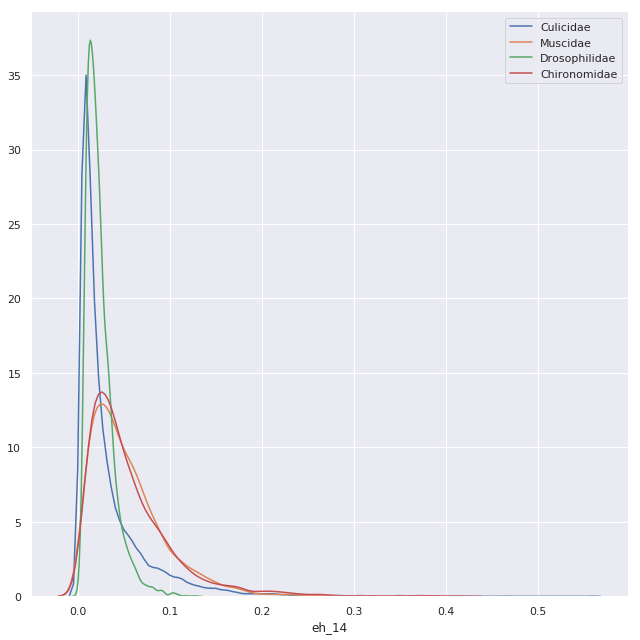



------------------------------------------------------------------------------------------------------------------------


		 eh_15


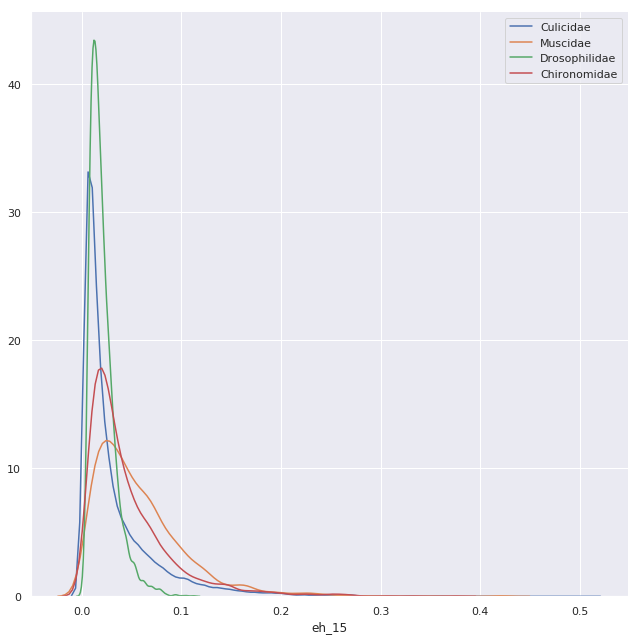



------------------------------------------------------------------------------------------------------------------------


		 eh_16


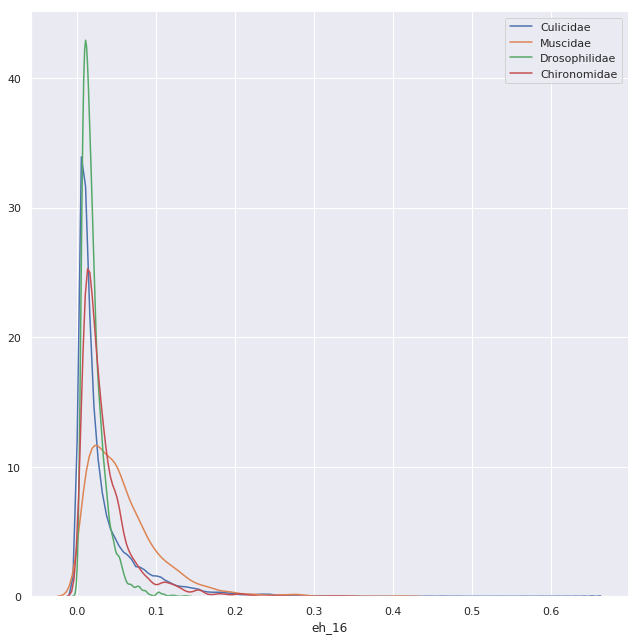



------------------------------------------------------------------------------------------------------------------------


		 eh_17


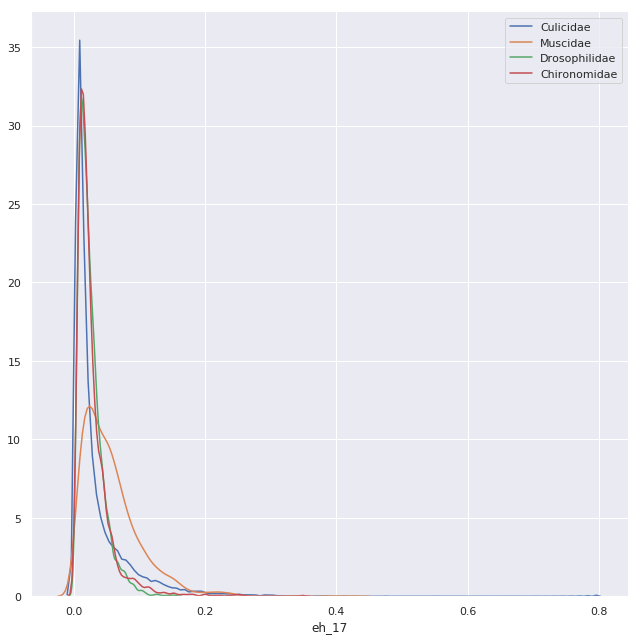



------------------------------------------------------------------------------------------------------------------------


		 eh_18


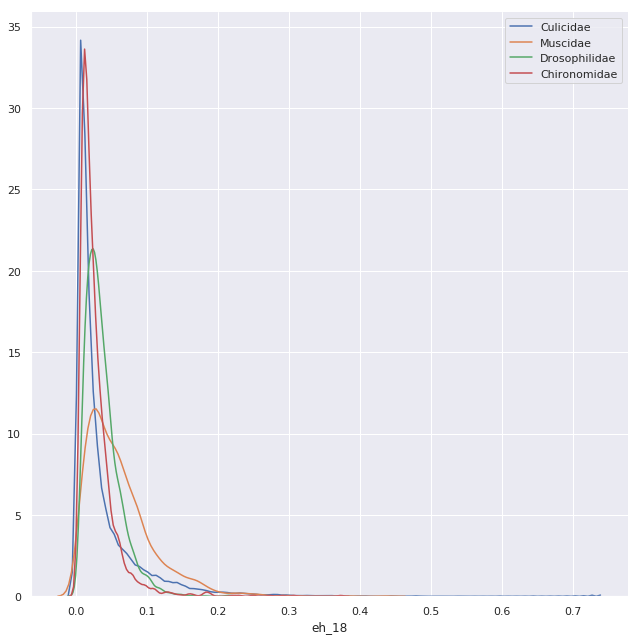



------------------------------------------------------------------------------------------------------------------------


		 eh_19


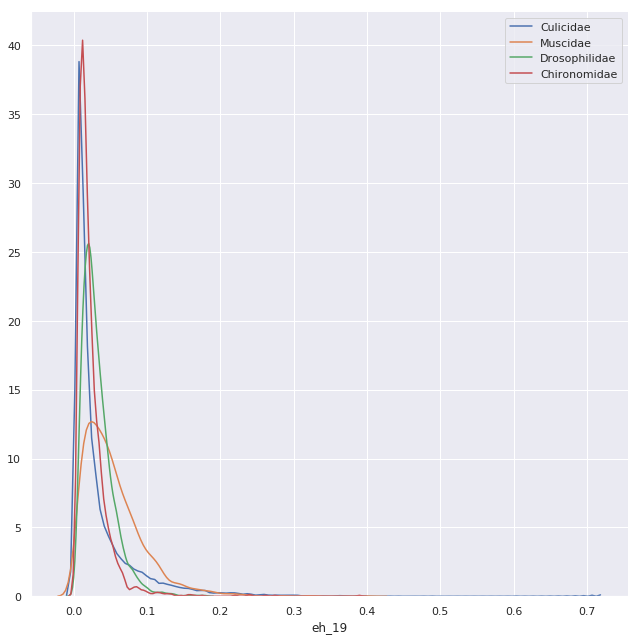



------------------------------------------------------------------------------------------------------------------------


		 eh_20


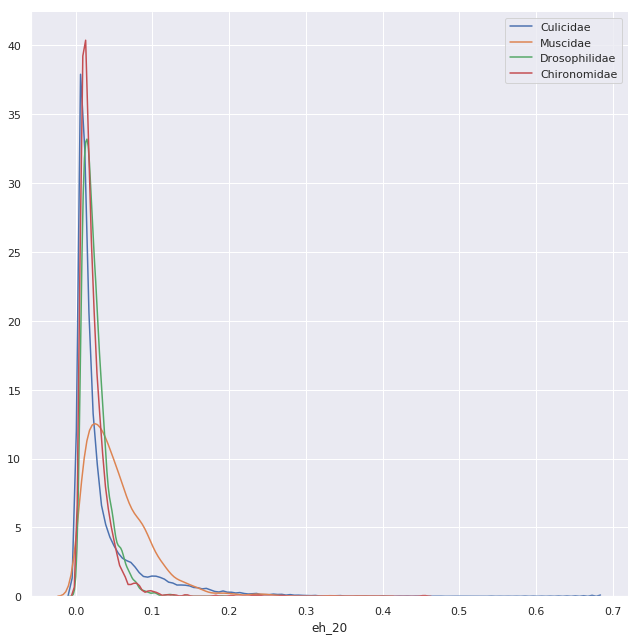



------------------------------------------------------------------------------------------------------------------------


		 eh_21


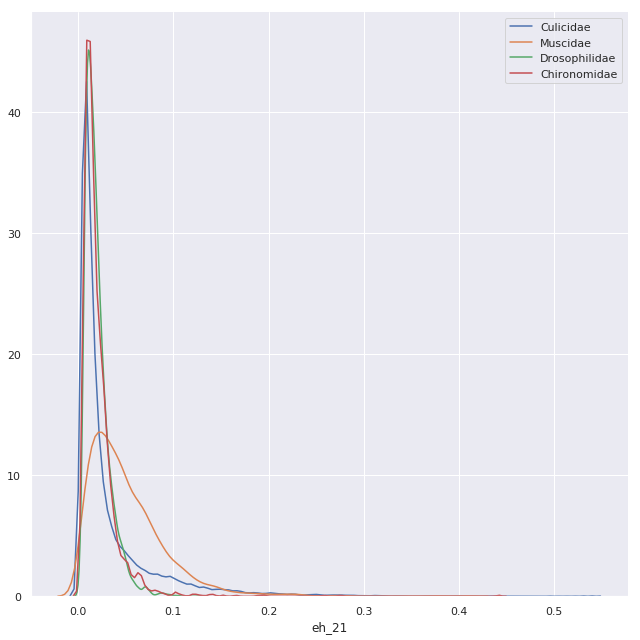



------------------------------------------------------------------------------------------------------------------------


		 eh_22


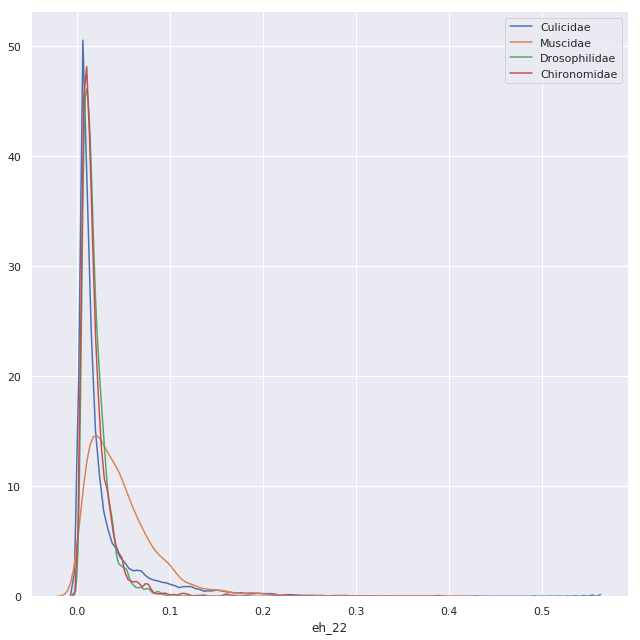



------------------------------------------------------------------------------------------------------------------------


		 eh_23


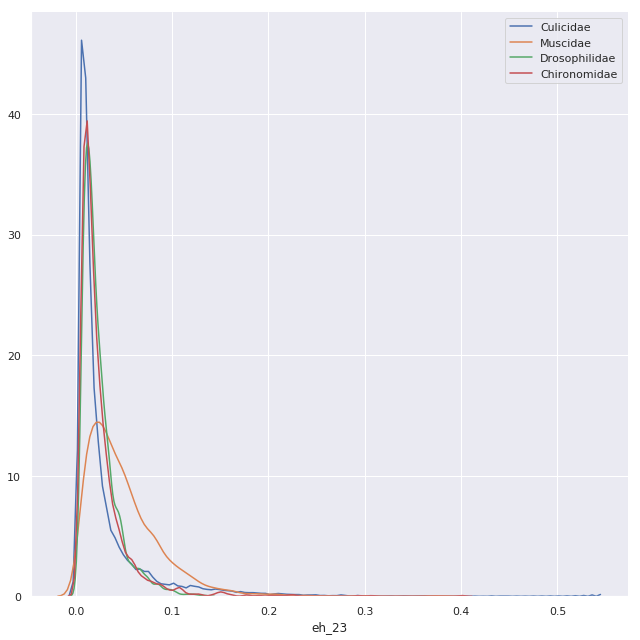



------------------------------------------------------------------------------------------------------------------------


		 eh_24


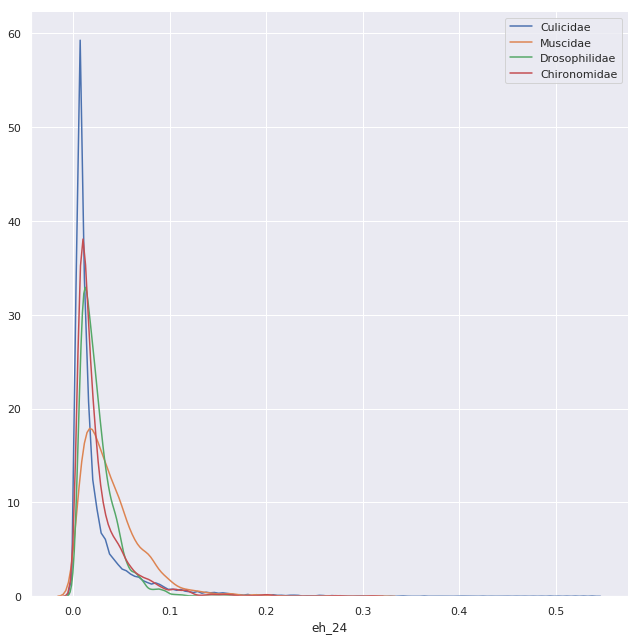



------------------------------------------------------------------------------------------------------------------------


		 eh_25


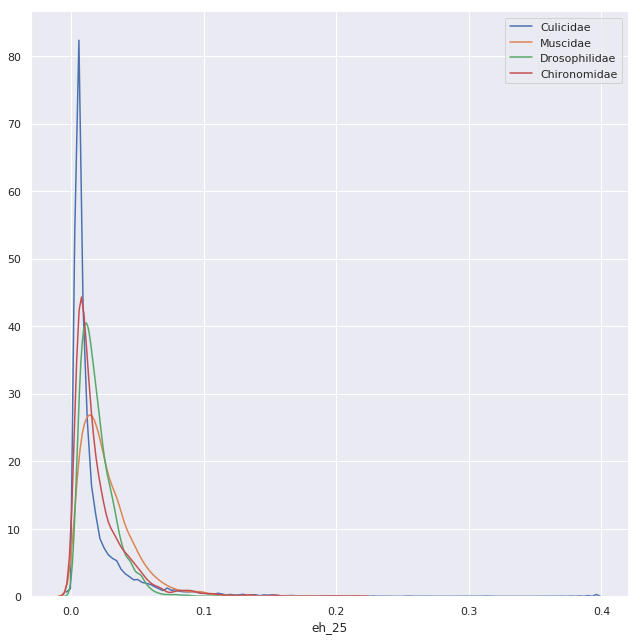



------------------------------------------------------------------------------------------------------------------------


		 eh_26


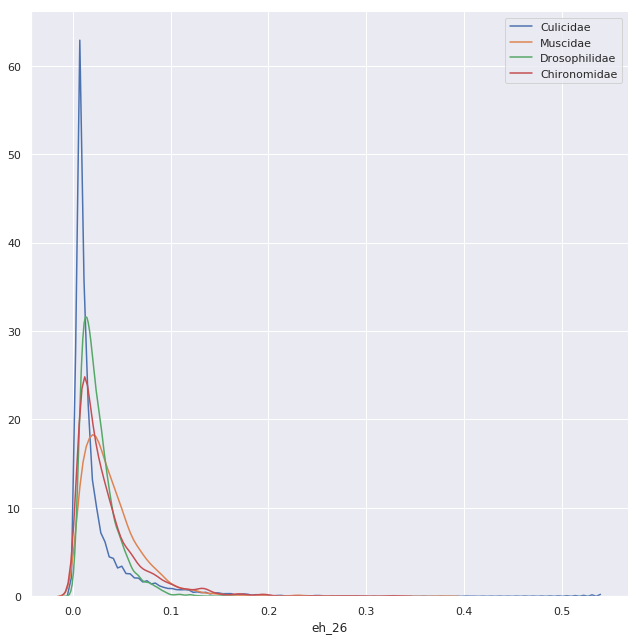



------------------------------------------------------------------------------------------------------------------------


		 class


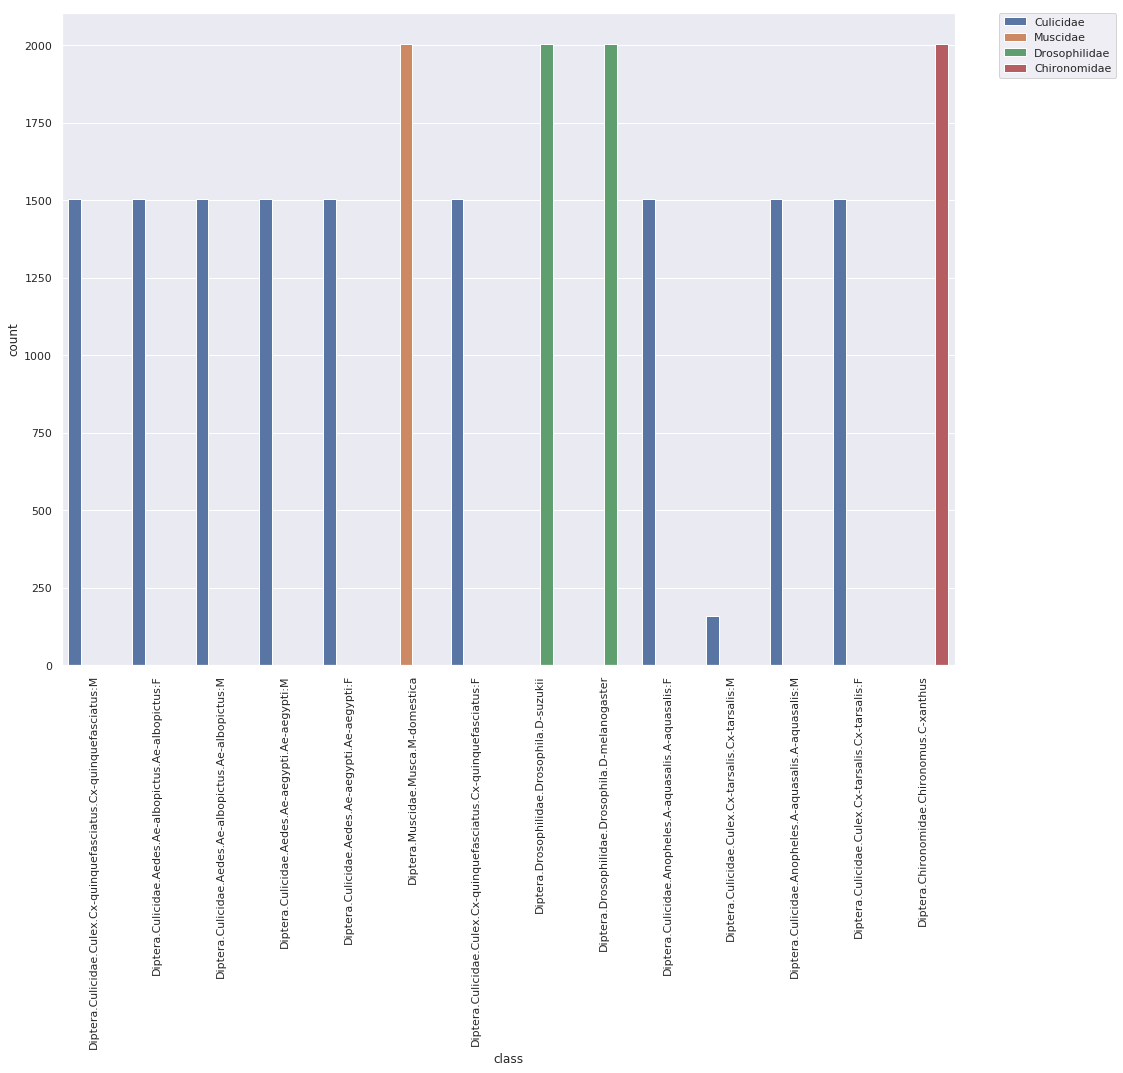



------------------------------------------------------------------------------------------------------------------------


		 level1


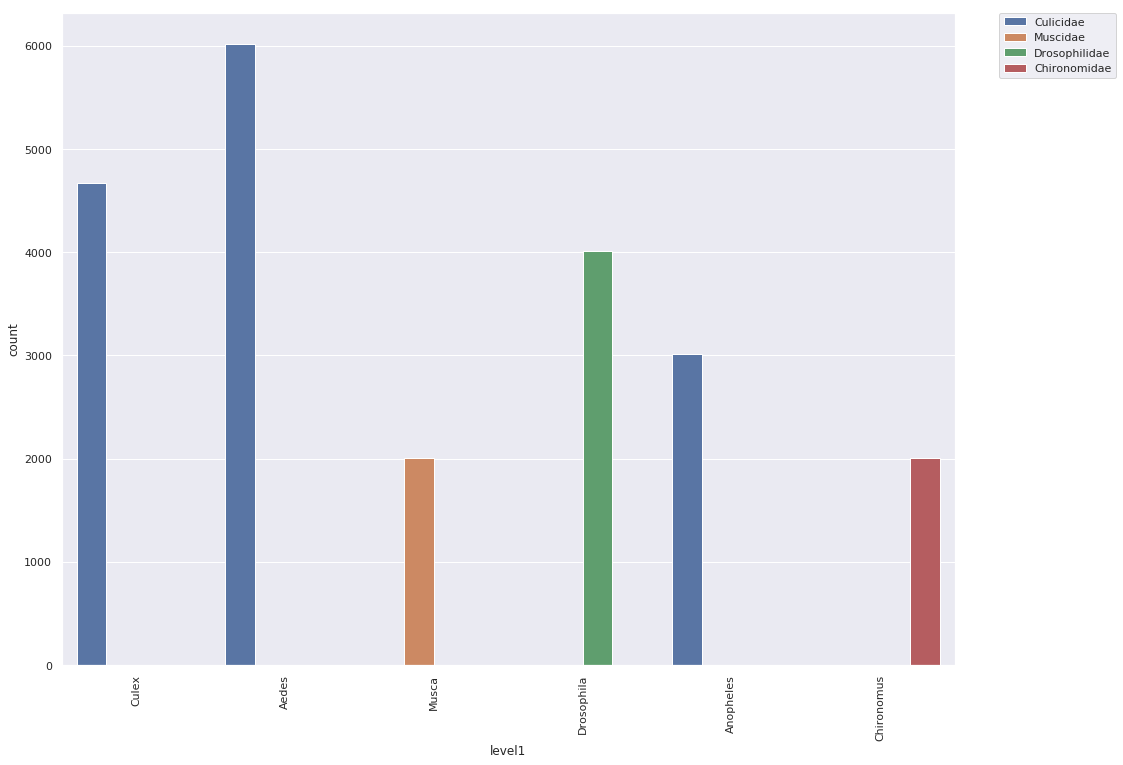



------------------------------------------------------------------------------------------------------------------------


		 level2


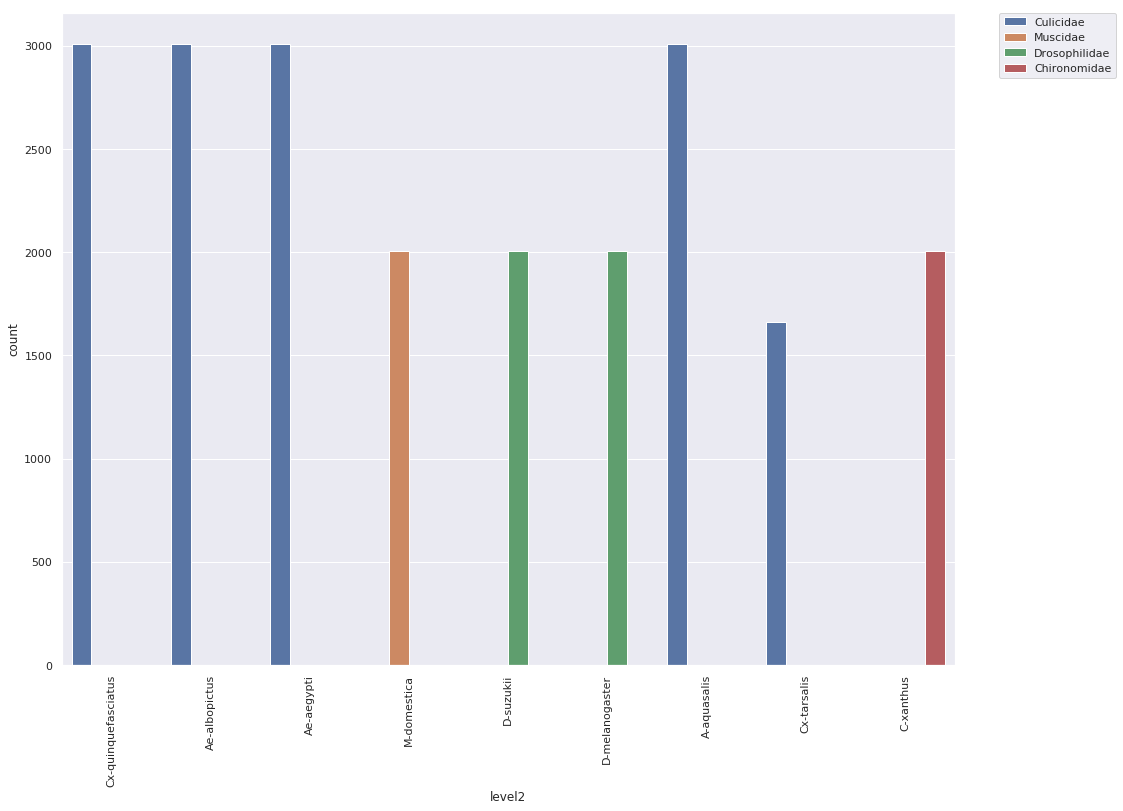



------------------------------------------------------------------------------------------------------------------------


		 level3


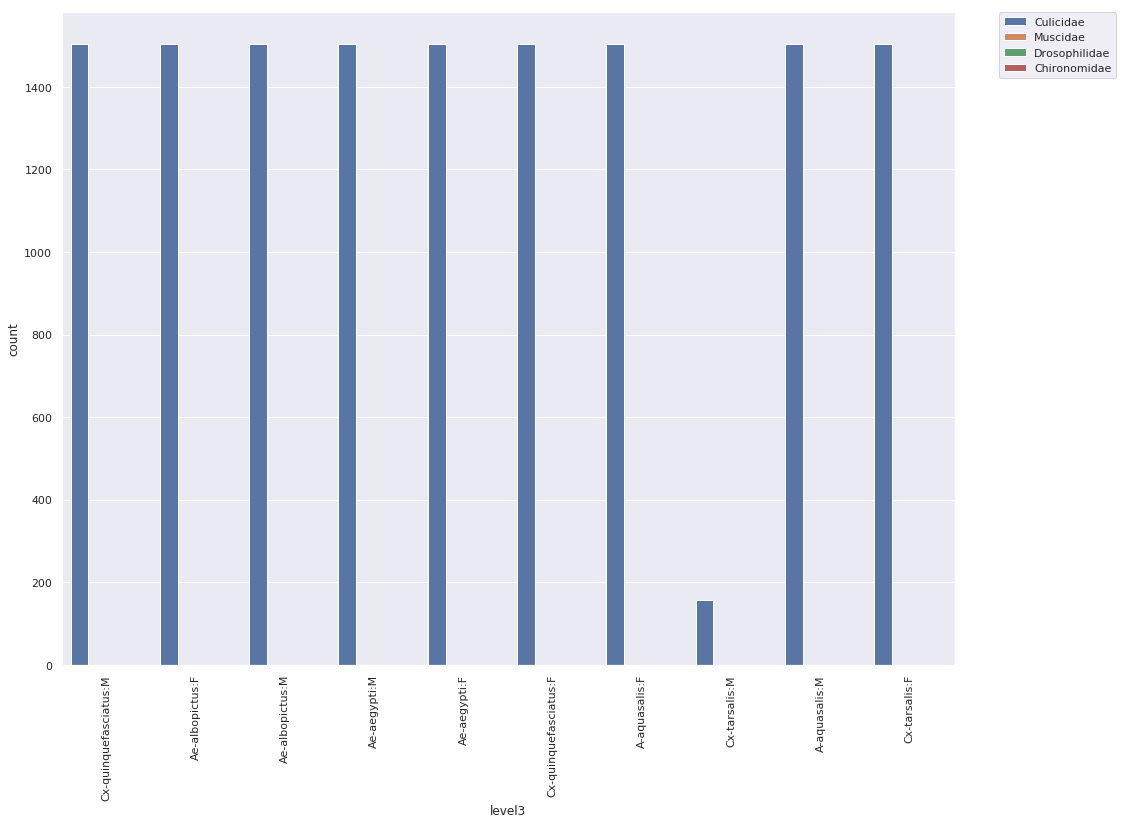



------------------------------------------------------------------------------------------------------------------------




In [6]:
if __name__ == "__main__" and '__file__' not in globals():
    dist_columns(merged_df)



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Considering only Ae Aegypti

		 peaks_freq_1


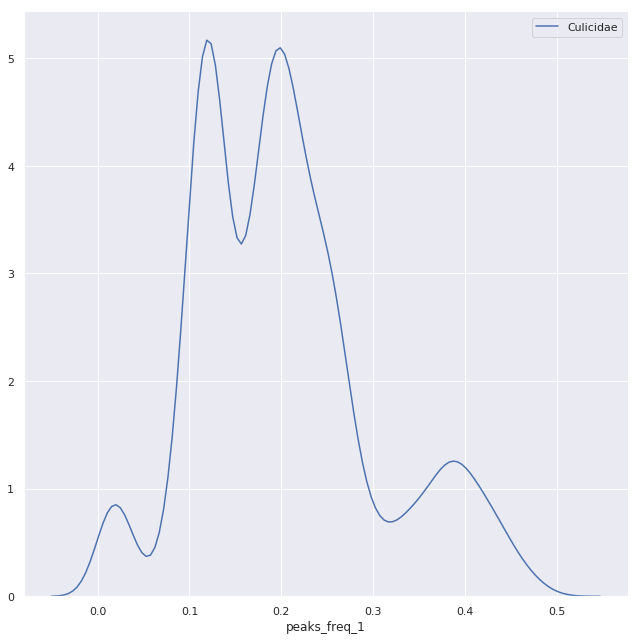



------------------------------------------------------------------------------------------------------------------------


		 peaks_freq_2


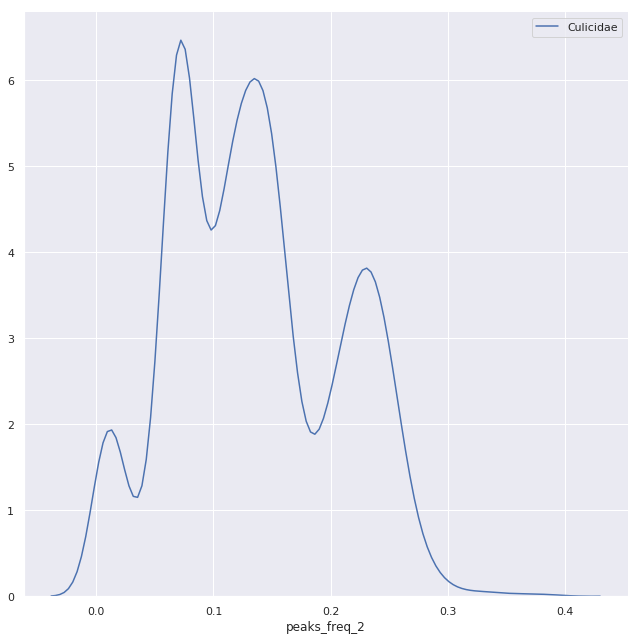



------------------------------------------------------------------------------------------------------------------------


		 peaks_freq_3


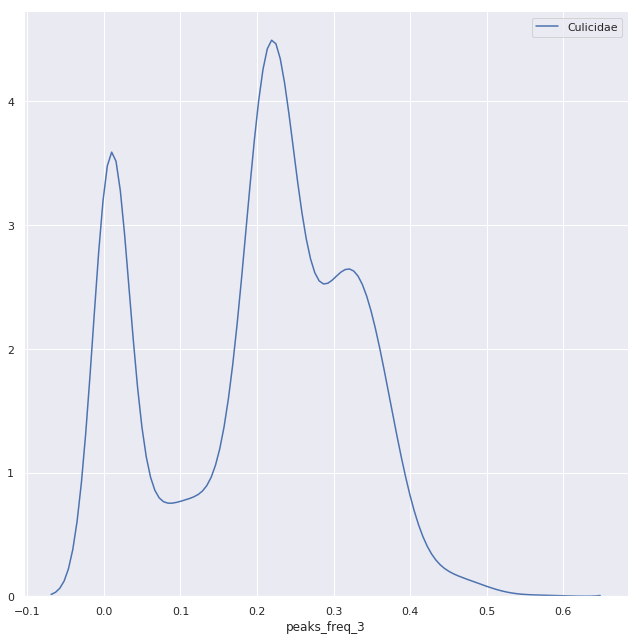



------------------------------------------------------------------------------------------------------------------------


		 peaks_freq_4


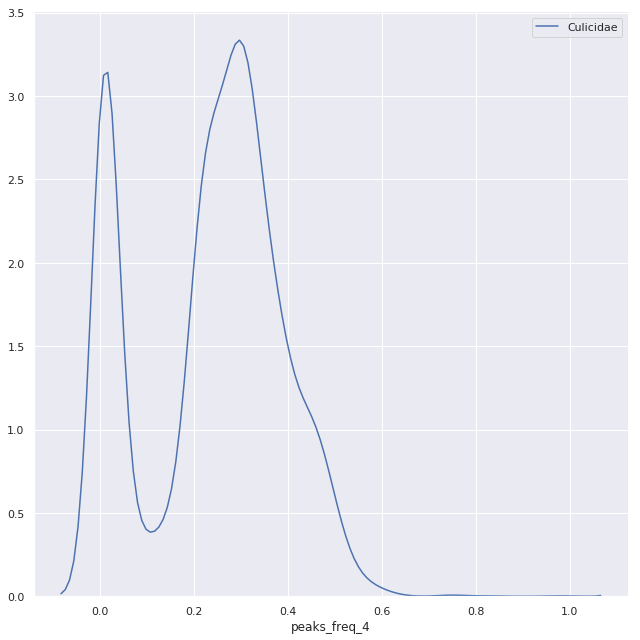



------------------------------------------------------------------------------------------------------------------------


		 peaks_freq_5


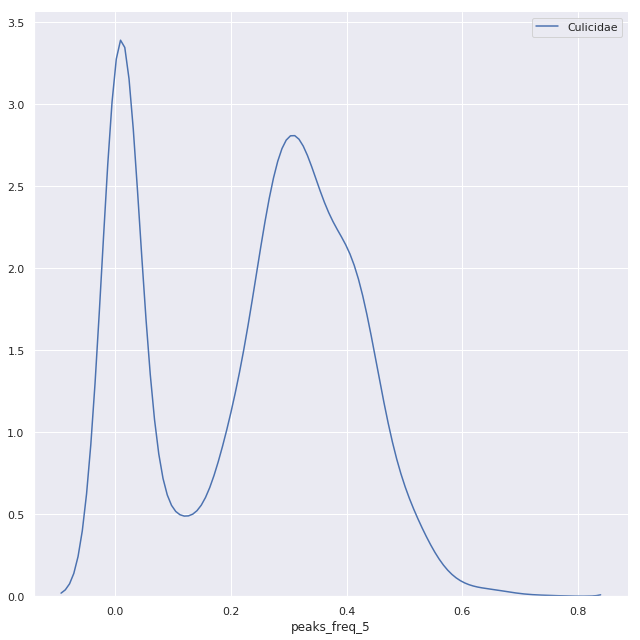



------------------------------------------------------------------------------------------------------------------------


		 peaks_freq_6


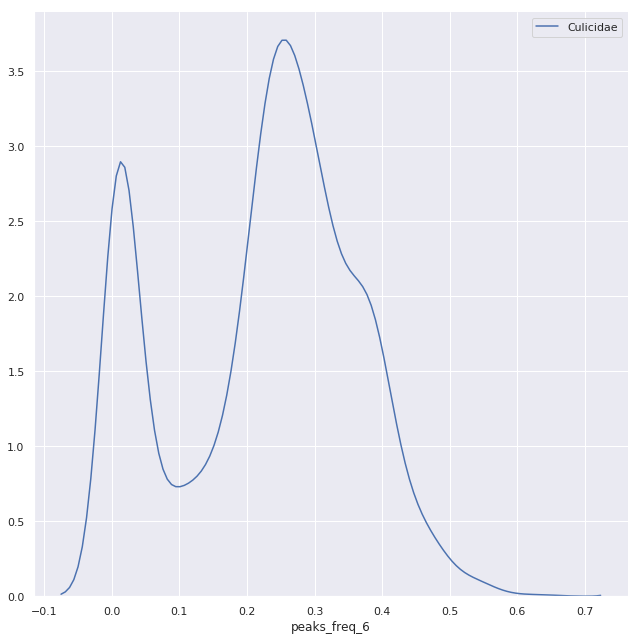



------------------------------------------------------------------------------------------------------------------------


		 inharmonicity


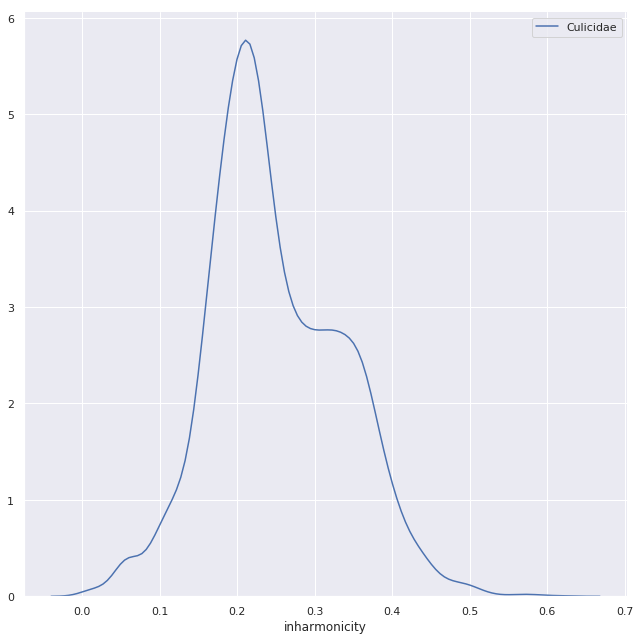



------------------------------------------------------------------------------------------------------------------------


		 eh_1


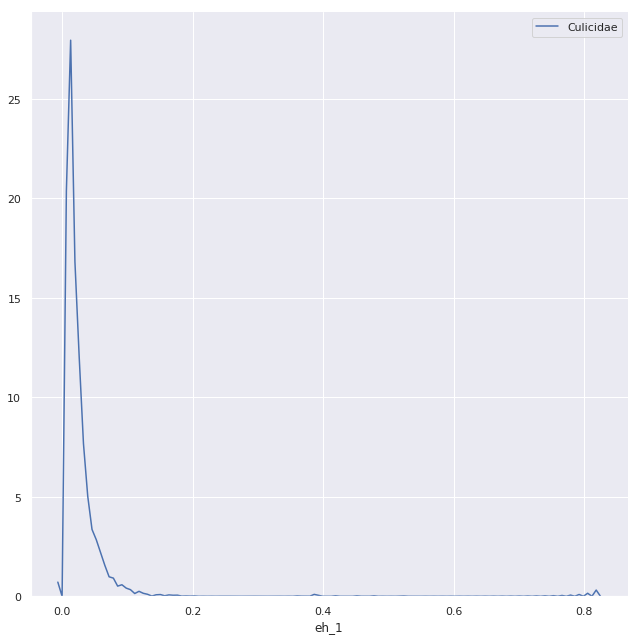



------------------------------------------------------------------------------------------------------------------------


		 eh_2


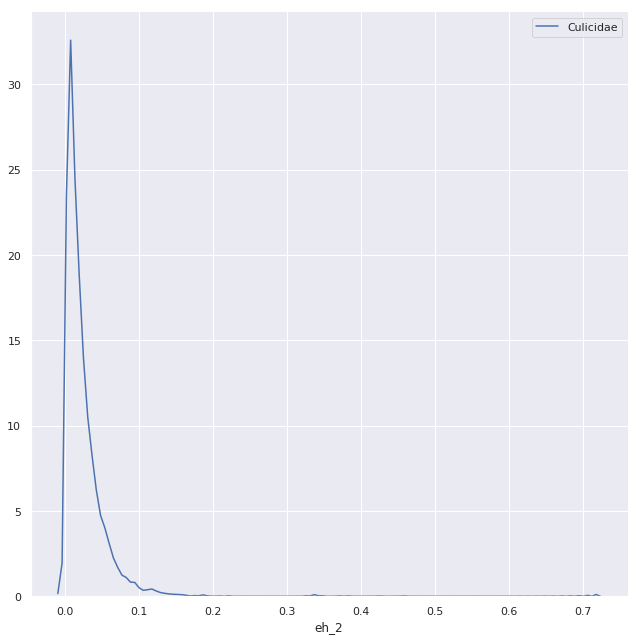



------------------------------------------------------------------------------------------------------------------------


		 eh_3


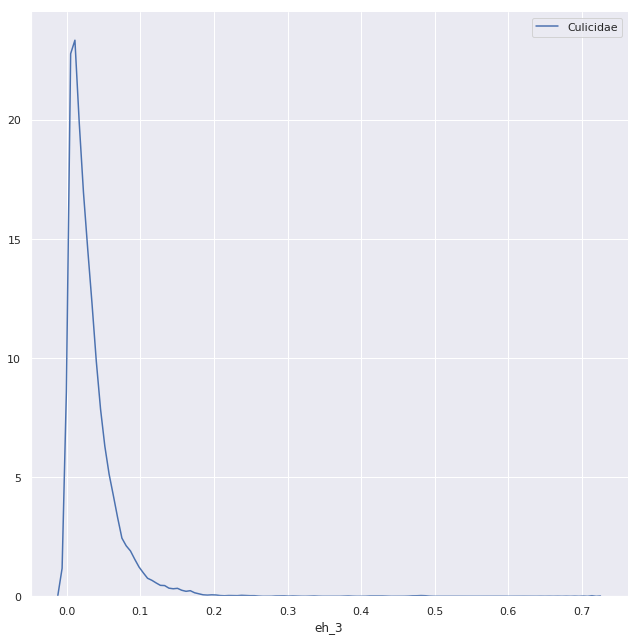



------------------------------------------------------------------------------------------------------------------------


		 eh_4


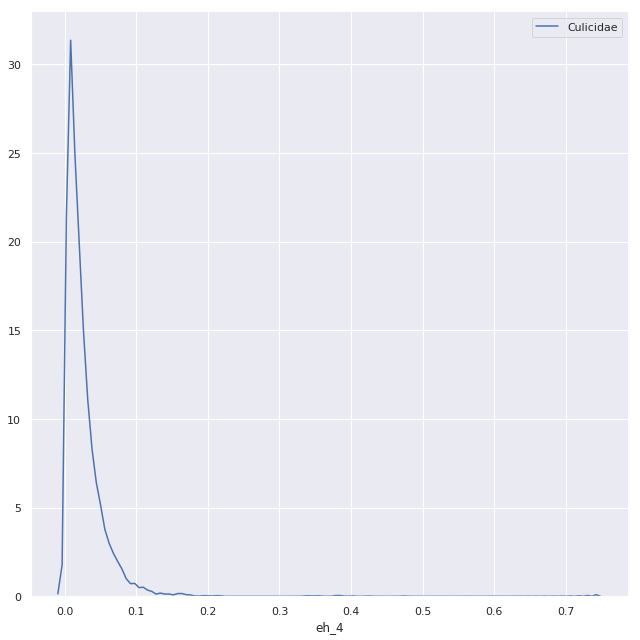



------------------------------------------------------------------------------------------------------------------------


		 eh_5


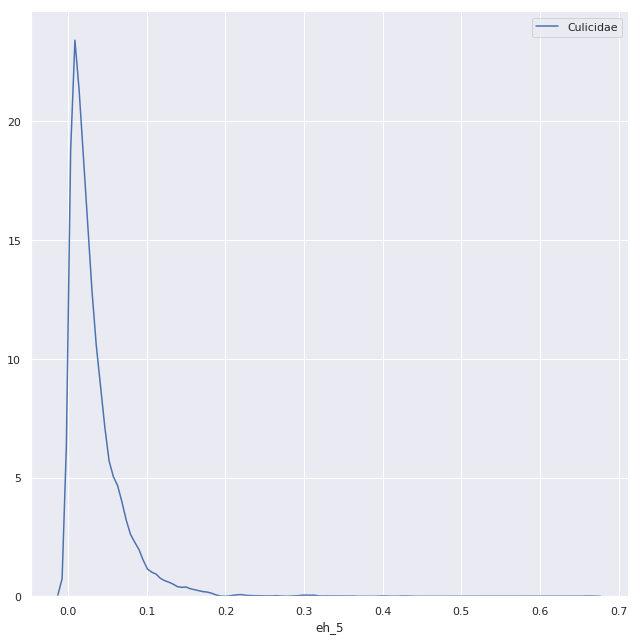



------------------------------------------------------------------------------------------------------------------------


		 eh_6


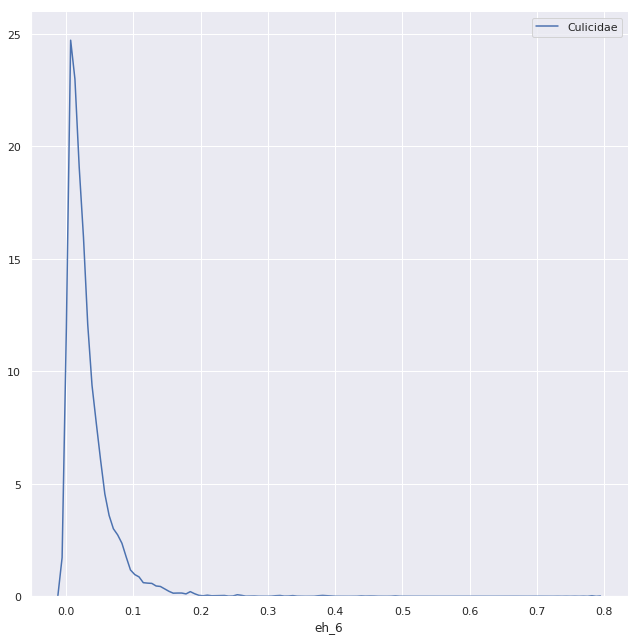



------------------------------------------------------------------------------------------------------------------------


		 eh_7


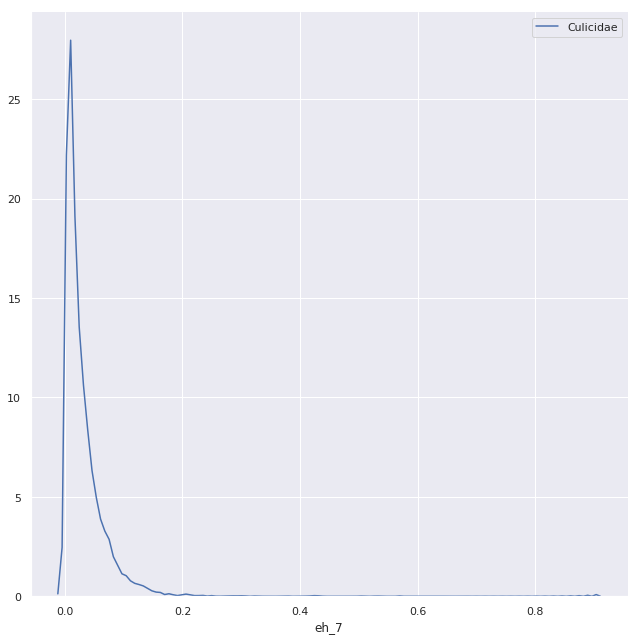



------------------------------------------------------------------------------------------------------------------------


		 eh_8


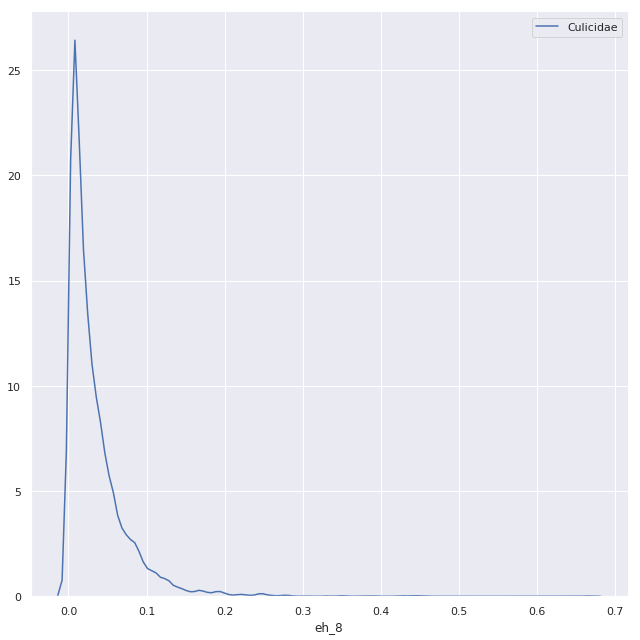



------------------------------------------------------------------------------------------------------------------------


		 eh_9


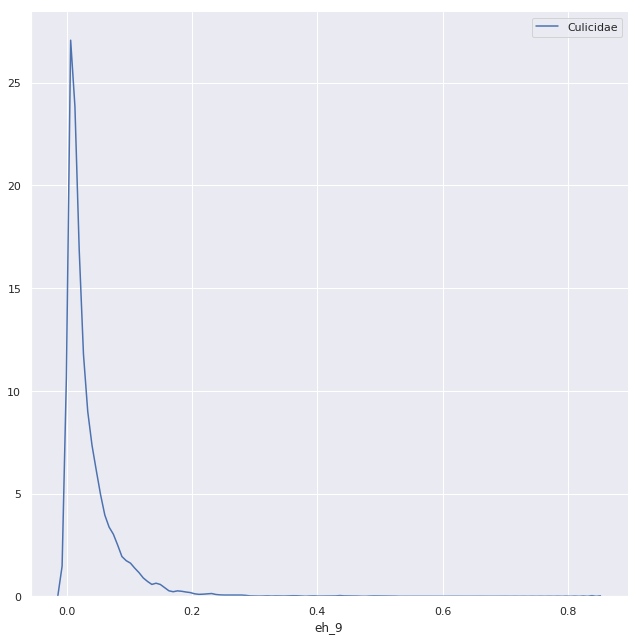



------------------------------------------------------------------------------------------------------------------------


		 eh_10


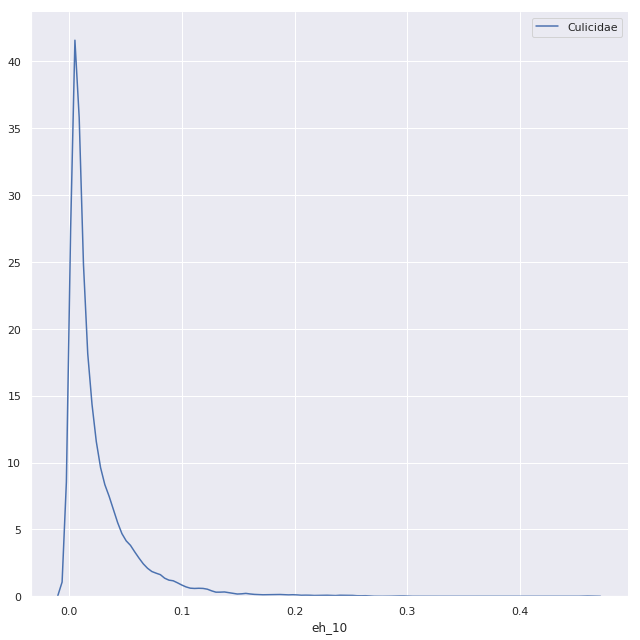



------------------------------------------------------------------------------------------------------------------------


		 eh_11


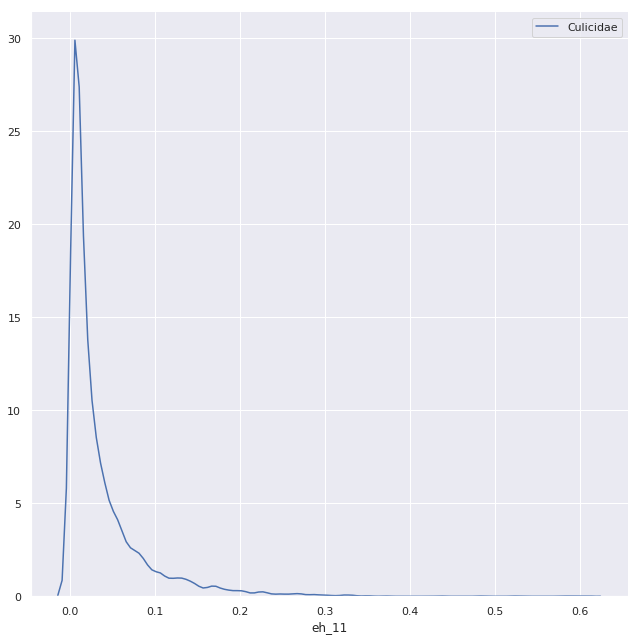



------------------------------------------------------------------------------------------------------------------------


		 eh_12


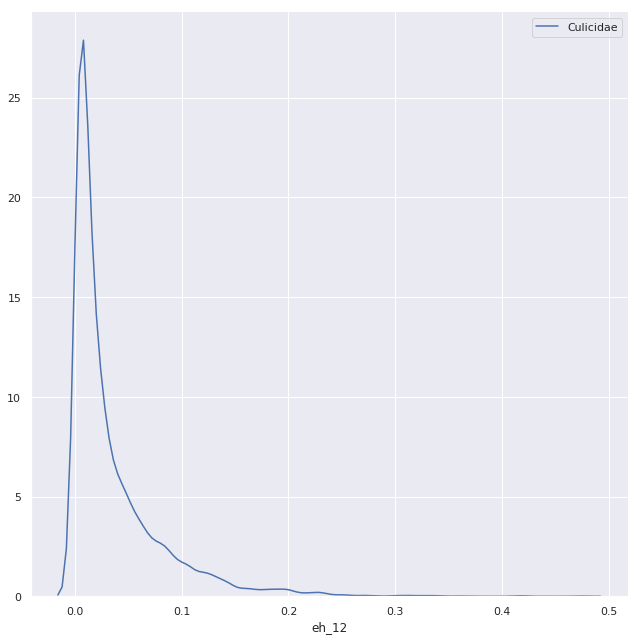



------------------------------------------------------------------------------------------------------------------------


		 eh_13


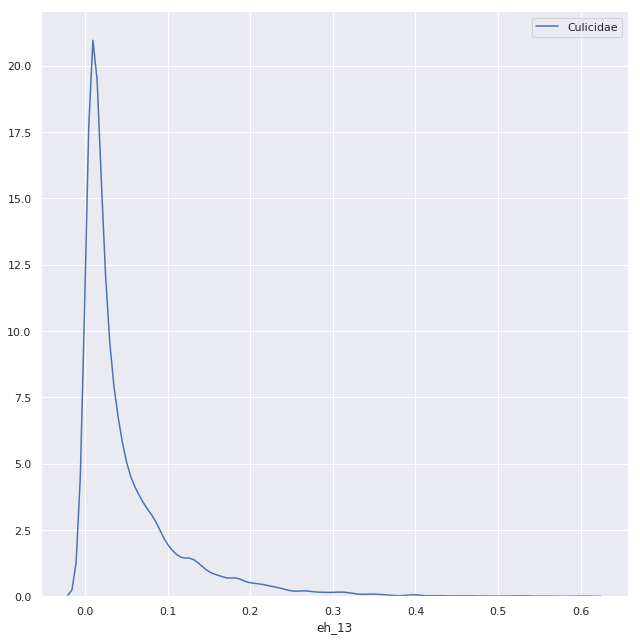



------------------------------------------------------------------------------------------------------------------------


		 eh_14


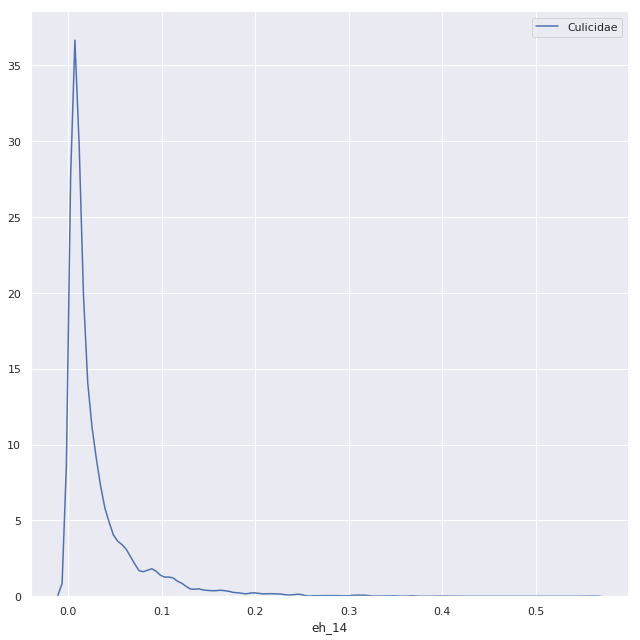



------------------------------------------------------------------------------------------------------------------------


		 eh_15


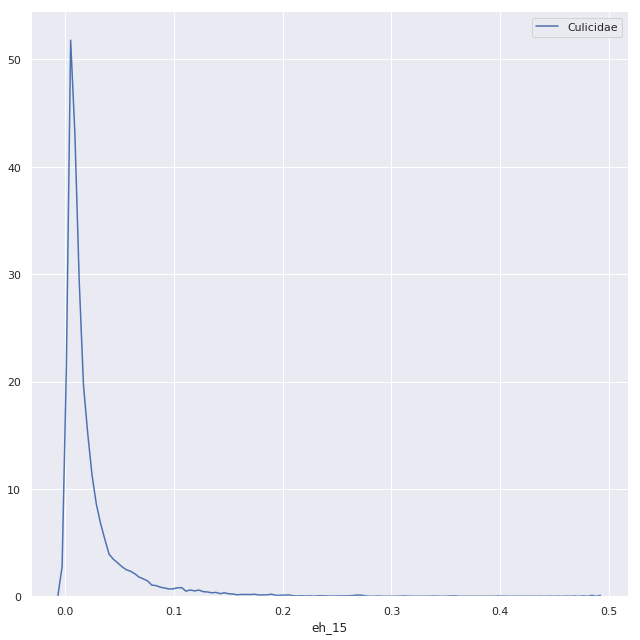



------------------------------------------------------------------------------------------------------------------------


		 eh_16


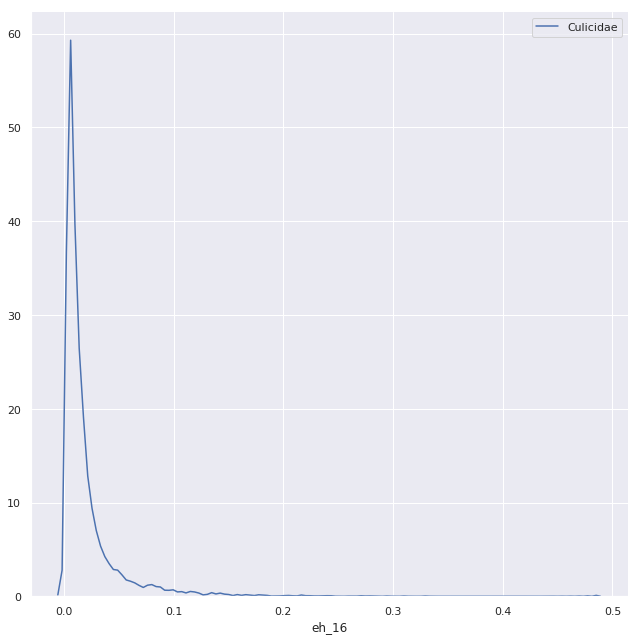



------------------------------------------------------------------------------------------------------------------------


		 eh_17


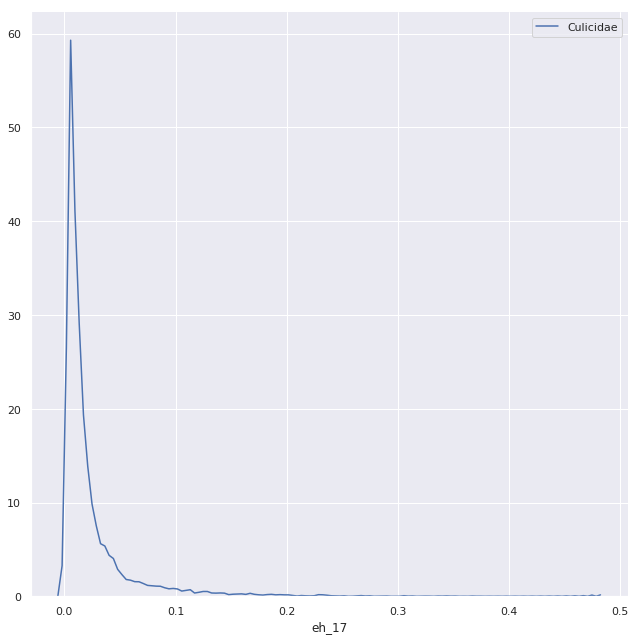



------------------------------------------------------------------------------------------------------------------------


		 eh_18


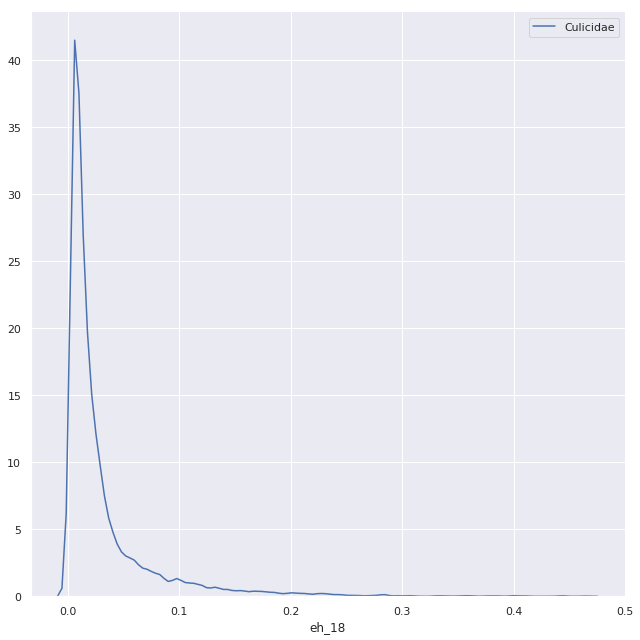



------------------------------------------------------------------------------------------------------------------------


		 eh_19


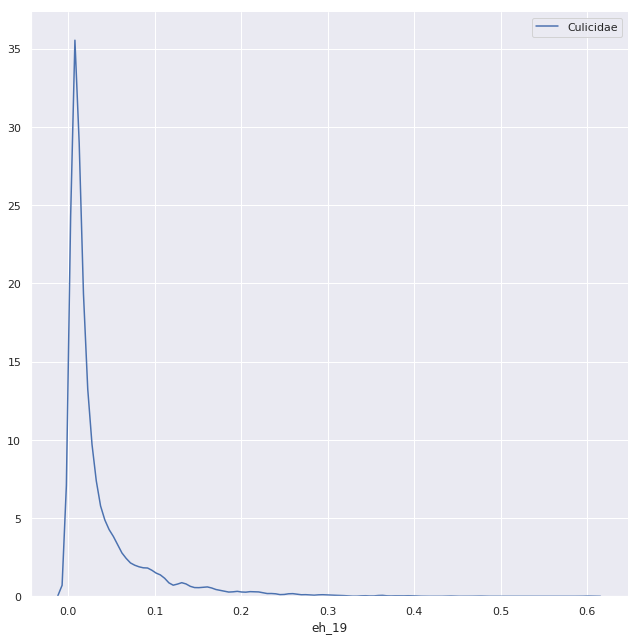



------------------------------------------------------------------------------------------------------------------------


		 eh_20


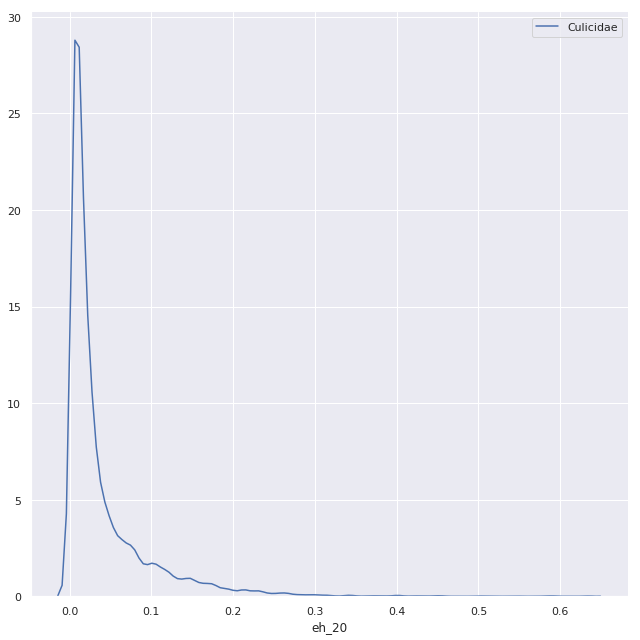



------------------------------------------------------------------------------------------------------------------------


		 eh_21


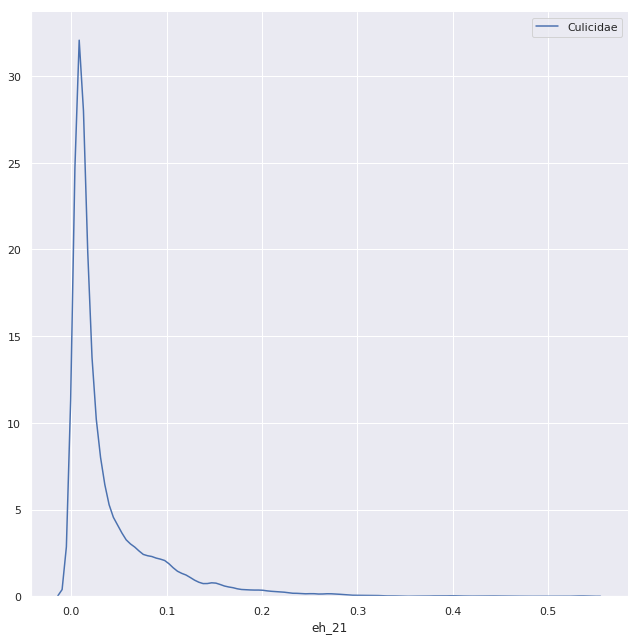



------------------------------------------------------------------------------------------------------------------------


		 eh_22


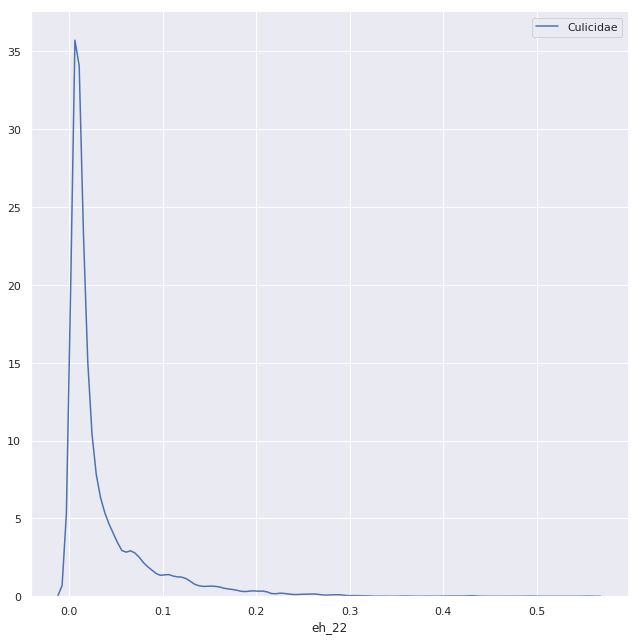



------------------------------------------------------------------------------------------------------------------------


		 eh_23


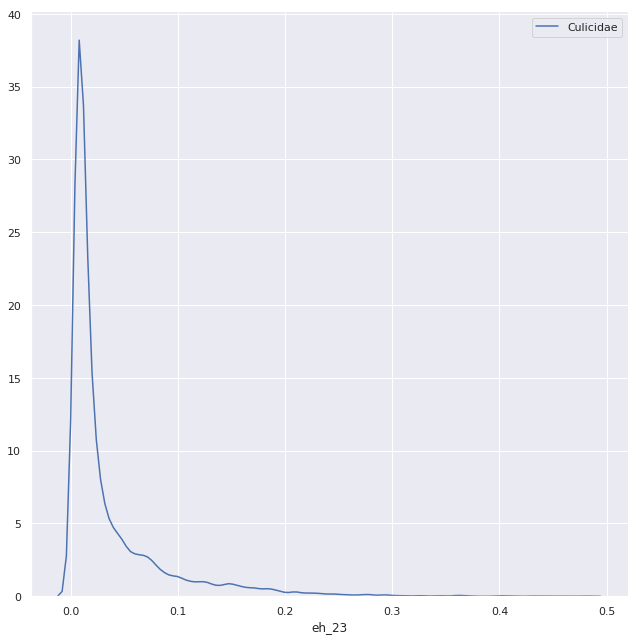



------------------------------------------------------------------------------------------------------------------------


		 eh_24


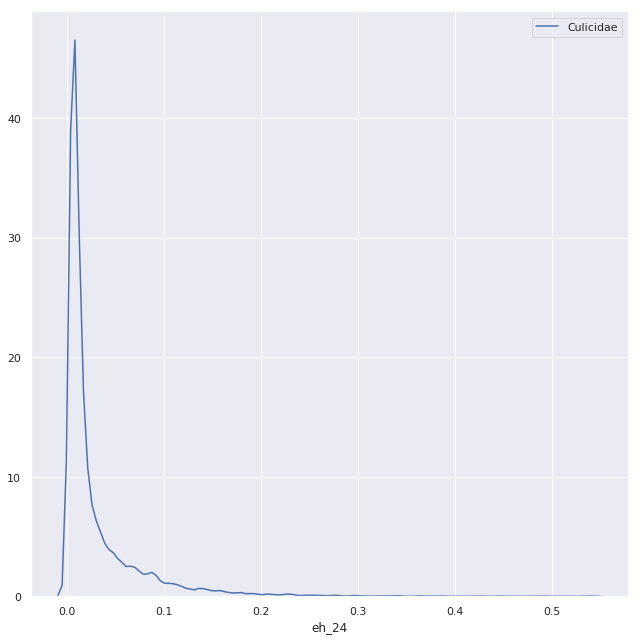



------------------------------------------------------------------------------------------------------------------------


		 eh_25


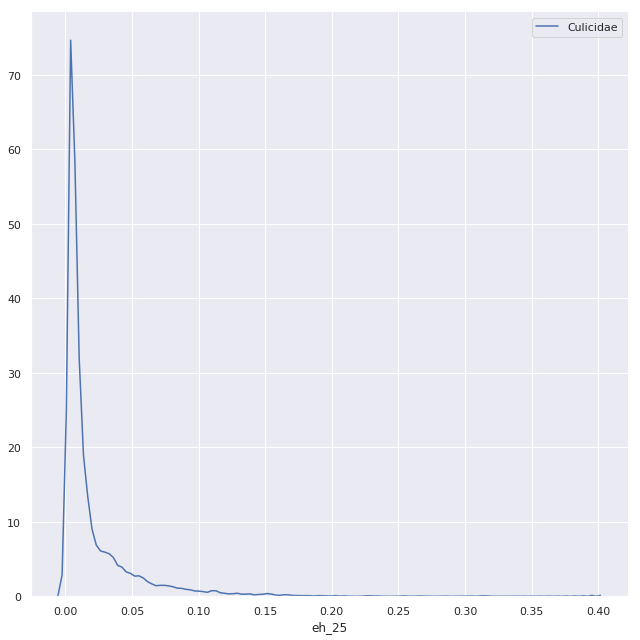



------------------------------------------------------------------------------------------------------------------------


		 eh_26


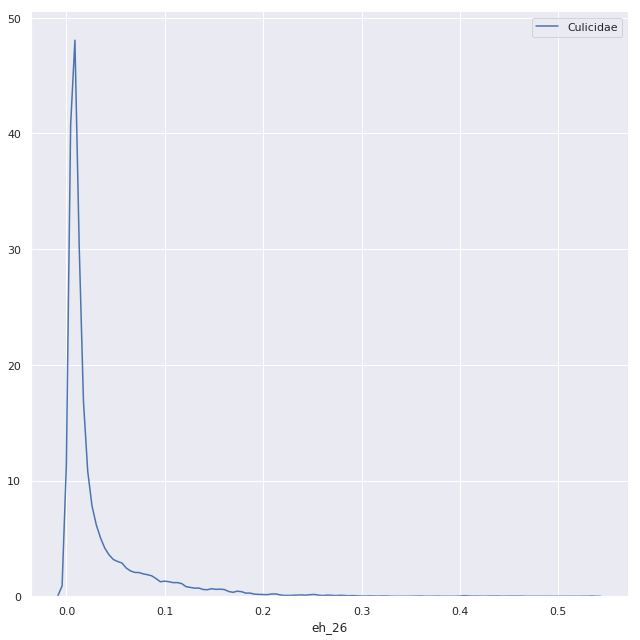



------------------------------------------------------------------------------------------------------------------------


		 class


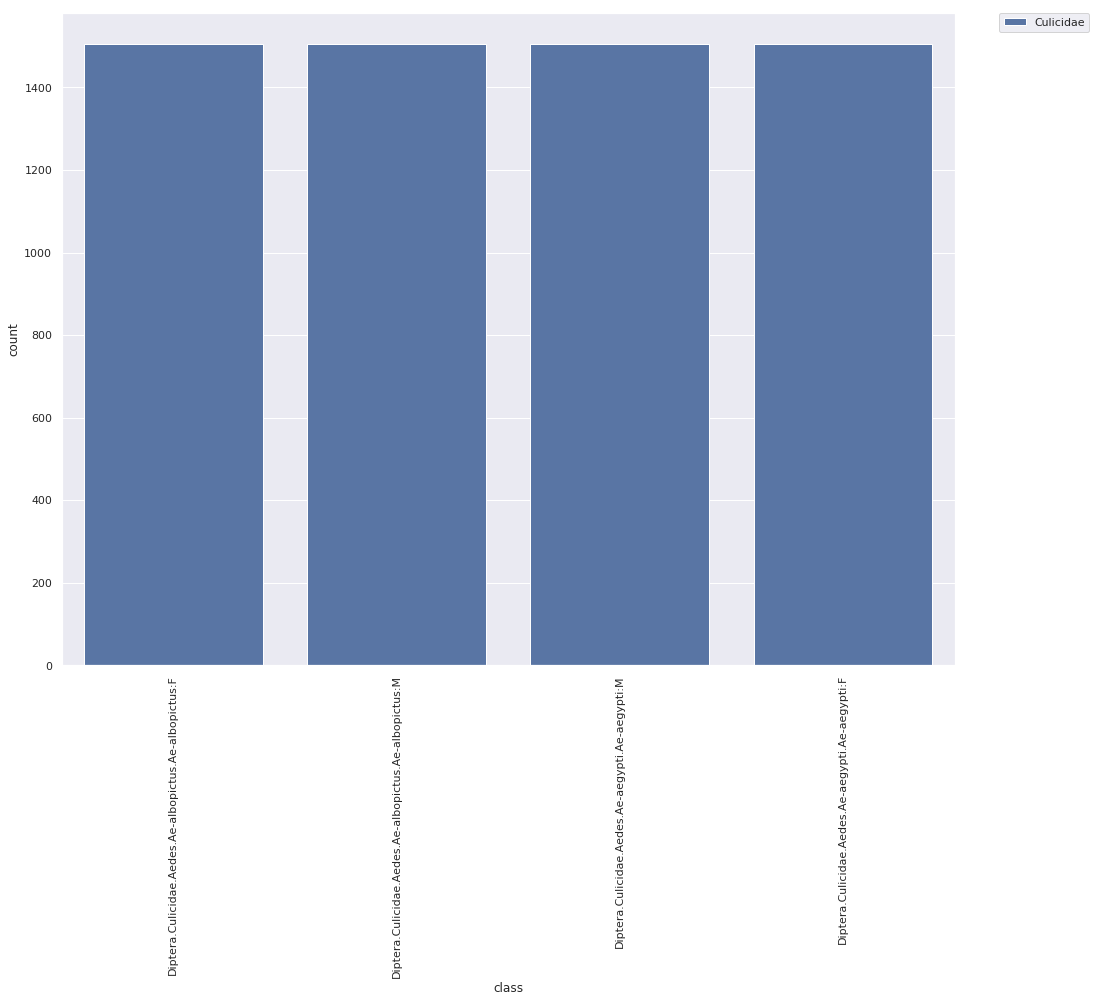



------------------------------------------------------------------------------------------------------------------------


		 level1


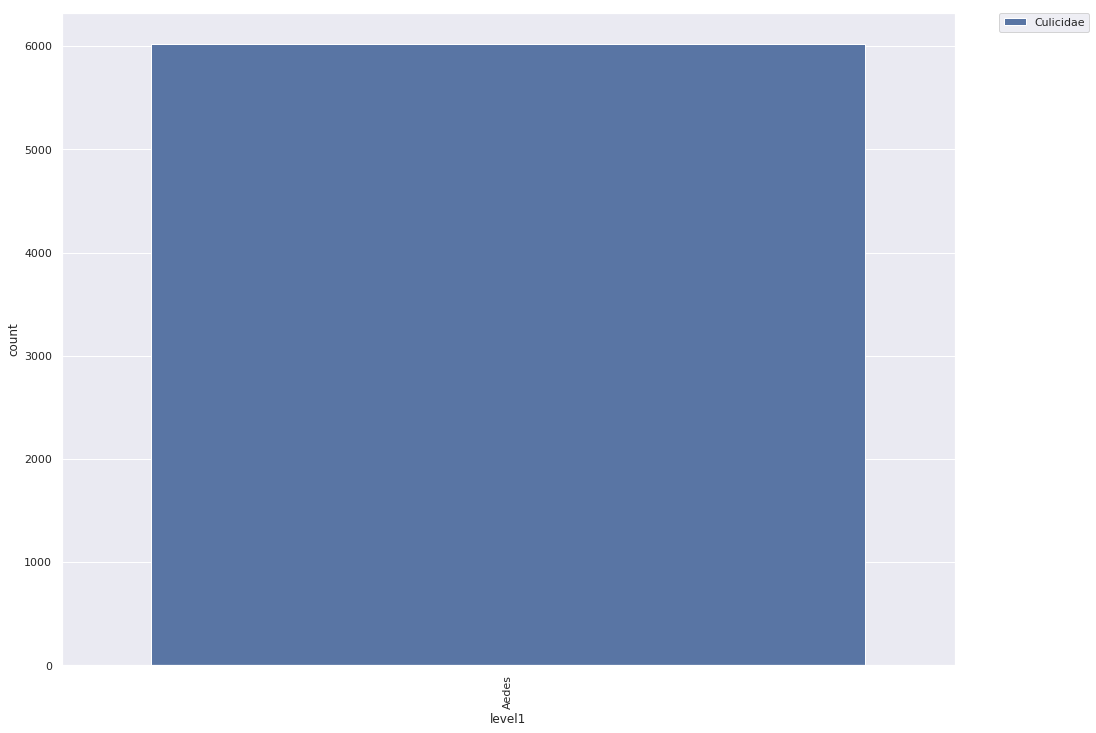



------------------------------------------------------------------------------------------------------------------------


		 level2


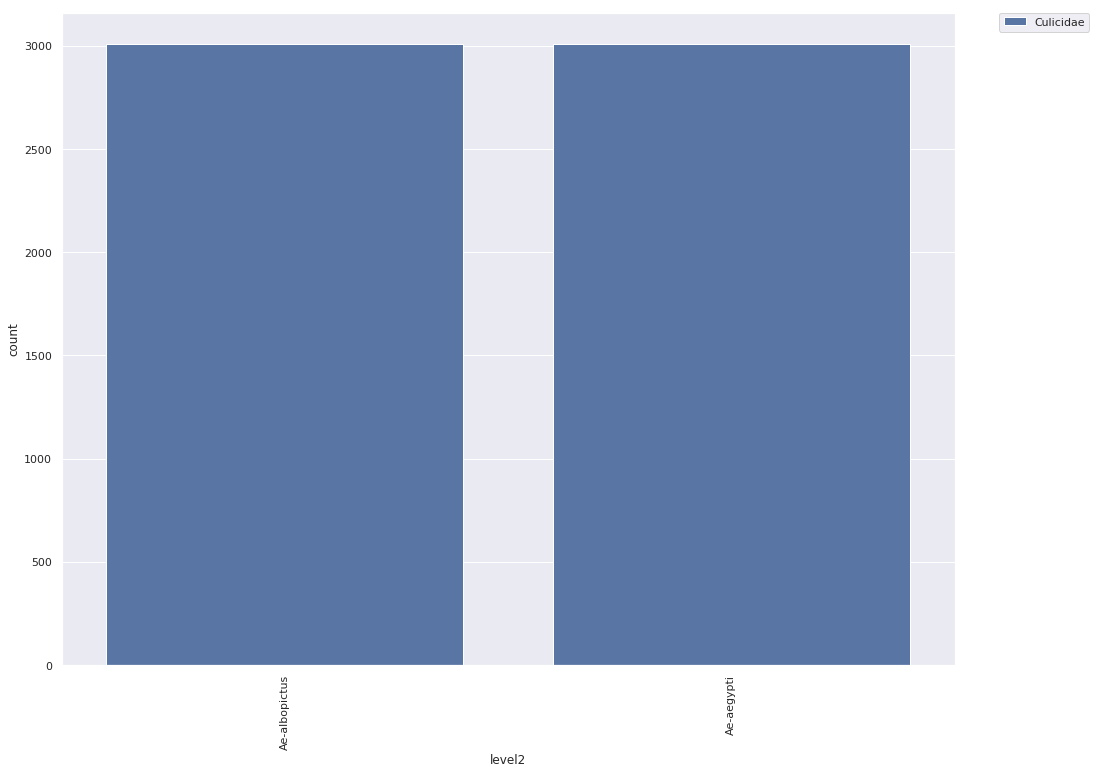



------------------------------------------------------------------------------------------------------------------------


		 level3


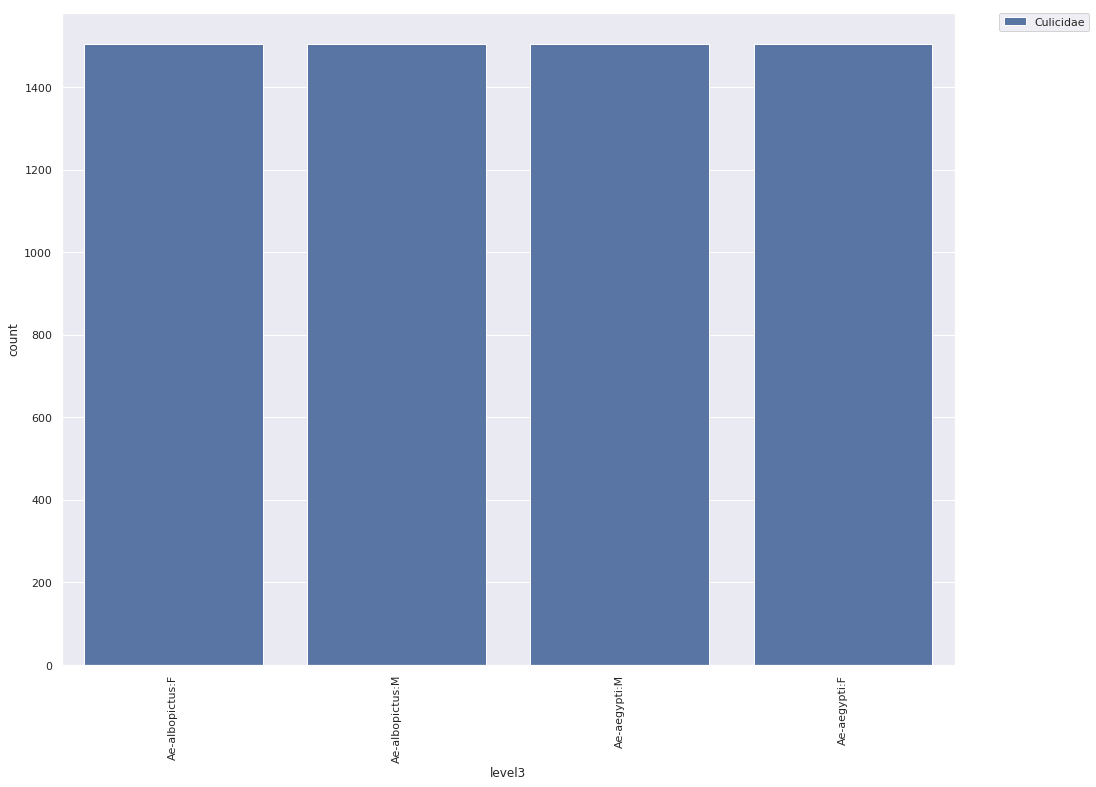



------------------------------------------------------------------------------------------------------------------------




In [7]:
if __name__ == "__main__" and '__file__' not in globals():
    idx = merged_df["level3"].str.contains("Ae", na=False)
    dist_columns(merged_df[idx])

- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Boxplots

		 peaks_freq_1


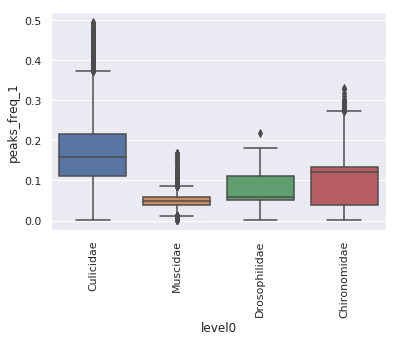



------------------------------------------------------------------------------------------------------------------------


		 peaks_freq_2


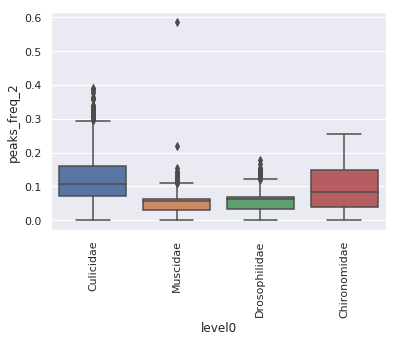



------------------------------------------------------------------------------------------------------------------------


		 peaks_freq_3


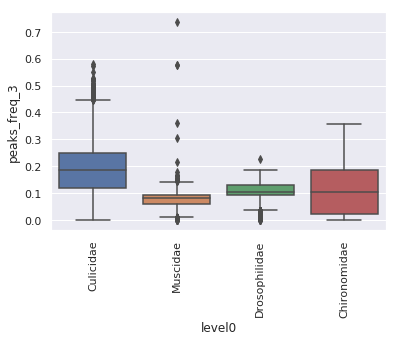



------------------------------------------------------------------------------------------------------------------------


		 peaks_freq_4


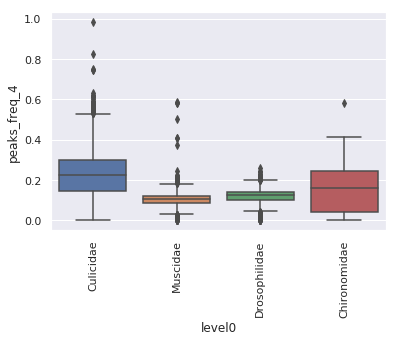



------------------------------------------------------------------------------------------------------------------------


		 peaks_freq_5


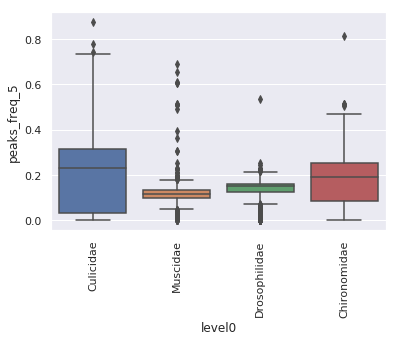



------------------------------------------------------------------------------------------------------------------------


		 peaks_freq_6


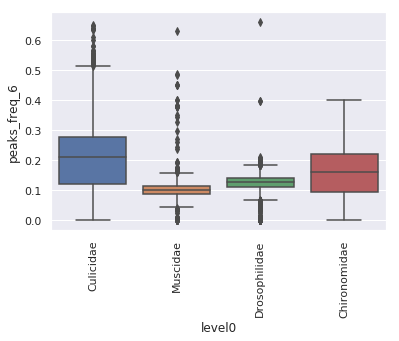



------------------------------------------------------------------------------------------------------------------------


		 inharmonicity


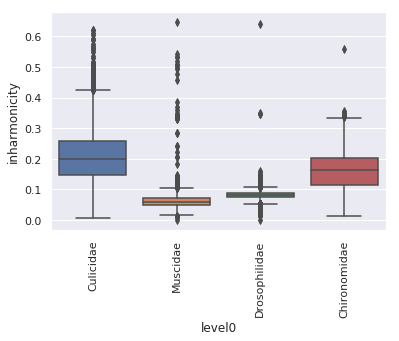



------------------------------------------------------------------------------------------------------------------------


		 eh_1


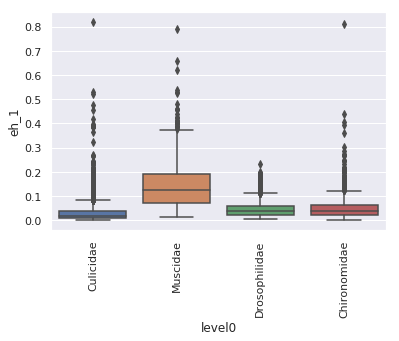



------------------------------------------------------------------------------------------------------------------------


		 eh_2


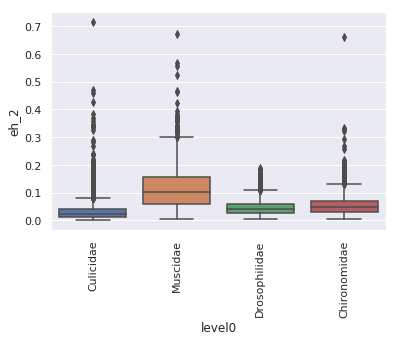



------------------------------------------------------------------------------------------------------------------------


		 eh_3


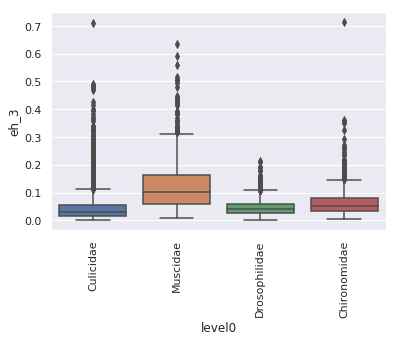



------------------------------------------------------------------------------------------------------------------------


		 eh_4


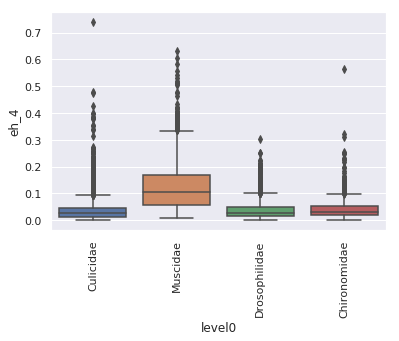



------------------------------------------------------------------------------------------------------------------------


		 eh_5


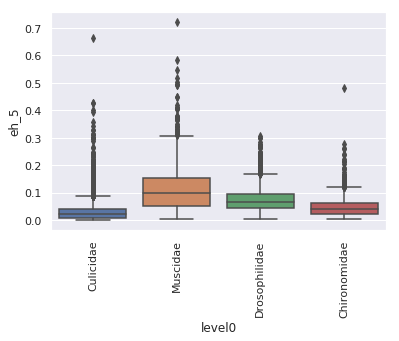



------------------------------------------------------------------------------------------------------------------------


		 eh_6


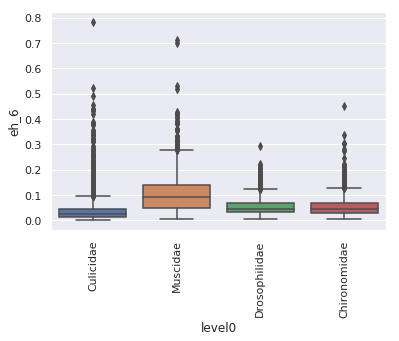



------------------------------------------------------------------------------------------------------------------------


		 eh_7


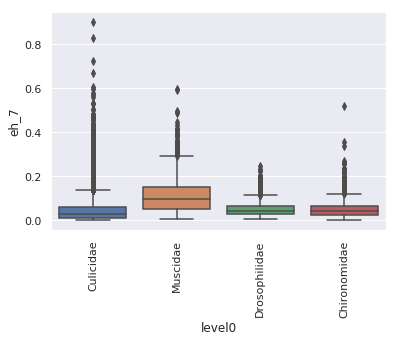



------------------------------------------------------------------------------------------------------------------------


		 eh_8


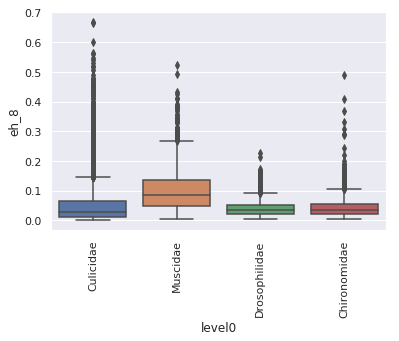



------------------------------------------------------------------------------------------------------------------------


		 eh_9


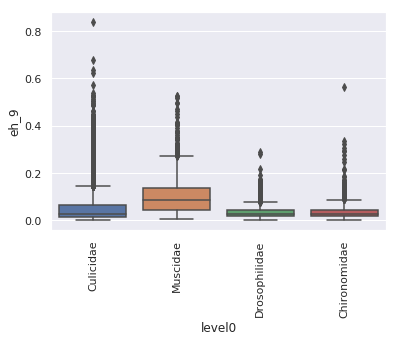



------------------------------------------------------------------------------------------------------------------------


		 eh_10


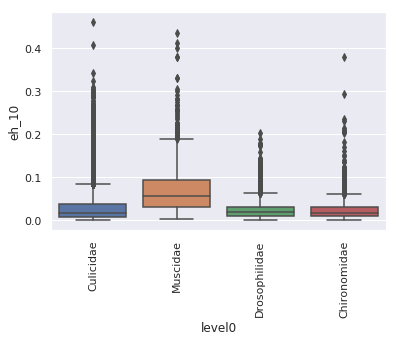



------------------------------------------------------------------------------------------------------------------------


		 eh_11


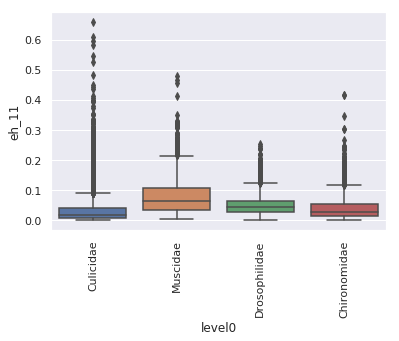



------------------------------------------------------------------------------------------------------------------------


		 eh_12


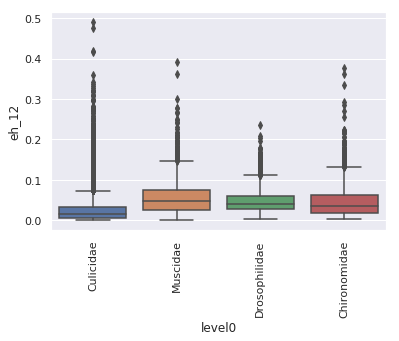



------------------------------------------------------------------------------------------------------------------------


		 eh_13


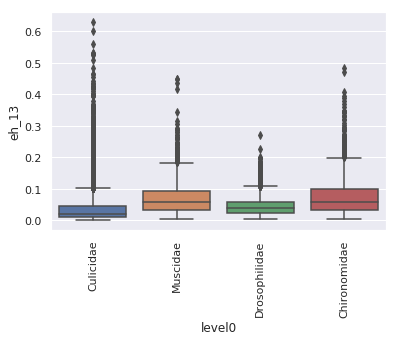



------------------------------------------------------------------------------------------------------------------------


		 eh_14


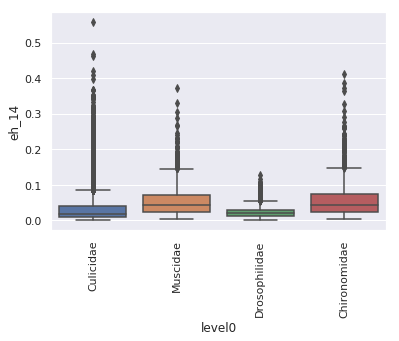



------------------------------------------------------------------------------------------------------------------------


		 eh_15


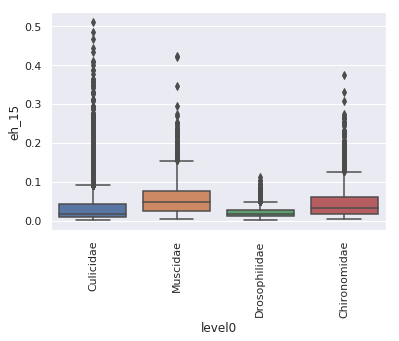



------------------------------------------------------------------------------------------------------------------------


		 eh_16


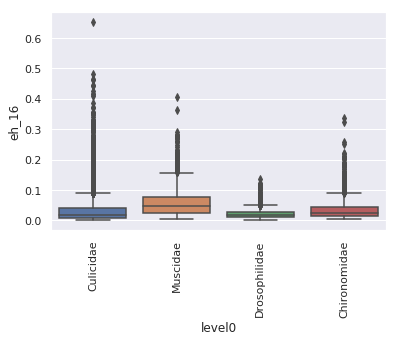



------------------------------------------------------------------------------------------------------------------------


		 eh_17


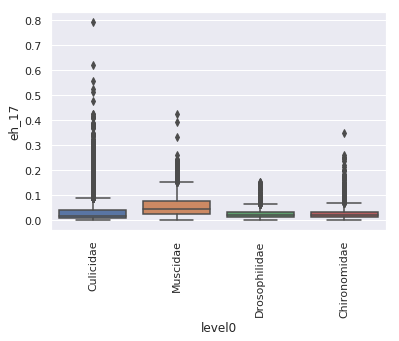



------------------------------------------------------------------------------------------------------------------------


		 eh_18


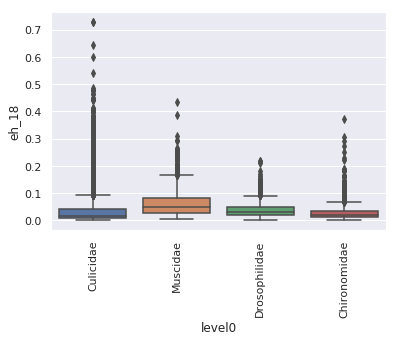



------------------------------------------------------------------------------------------------------------------------


		 eh_19


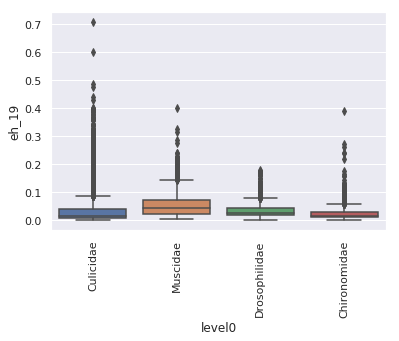



------------------------------------------------------------------------------------------------------------------------


		 eh_20


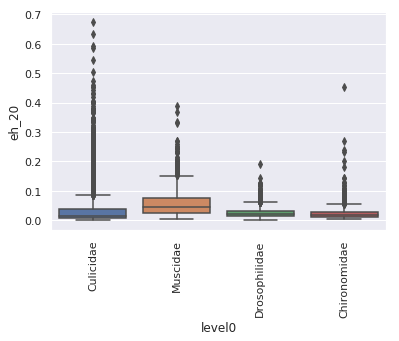



------------------------------------------------------------------------------------------------------------------------


		 eh_21


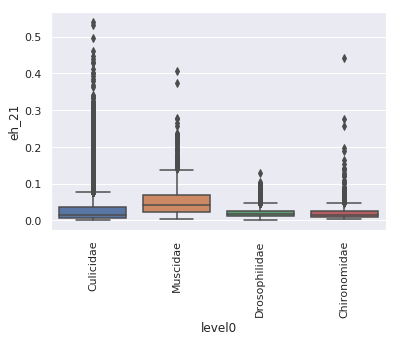



------------------------------------------------------------------------------------------------------------------------


		 eh_22


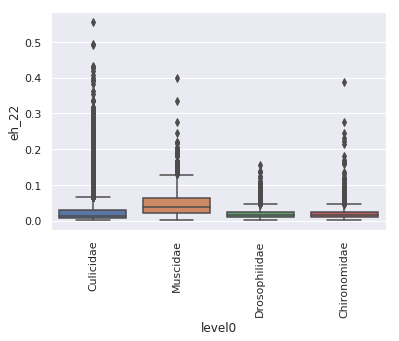



------------------------------------------------------------------------------------------------------------------------


		 eh_23


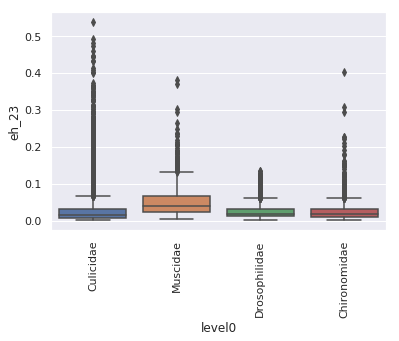



------------------------------------------------------------------------------------------------------------------------


		 eh_24


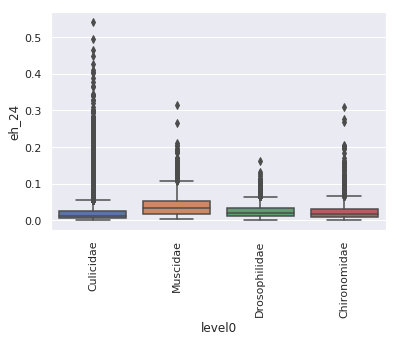



------------------------------------------------------------------------------------------------------------------------


		 eh_25


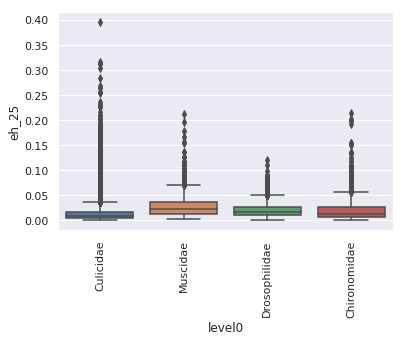



------------------------------------------------------------------------------------------------------------------------


		 eh_26


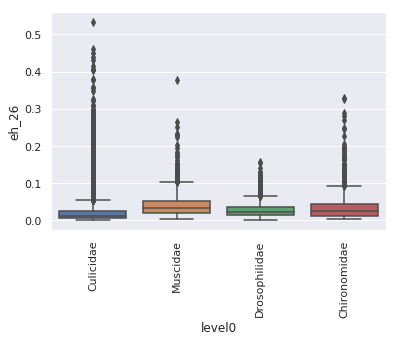



------------------------------------------------------------------------------------------------------------------------




In [8]:
if __name__ == "__main__" and '__file__' not in globals():
    boxplot_columns(merged_df)

- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Outliers

In [9]:
if __name__ == "__main__" and '__file__' not in globals():
    calculate_outliers(merged_df)

Remove any NaNs for outlier detection!

Error - could not process all cols for IQR analysis. Maybe differente types?
Could not operate array([nan, nan, nan, nan, nan]) with block values '<' not supported between instances of 'str' and 'float'
Error - could not process all cols for IQR analysis. Maybe differente types?
Could not operate array([nan, nan, nan, nan, nan]) with block values '<' not supported between instances of 'str' and 'float'
Error - could not process all cols for IQR analysis. Maybe differente types?
Could not operate array([nan, nan, nan, nan, nan]) with block values '<' not supported between instances of 'str' and 'float'


------------------------------------------------------------------------------------------------------------------------


Consdiering 1.5*IQR, we have....

Considering peaks_freq_1 	 we have 560  (4.086994599328565%) of outliers

Considering peaks_freq_2 	 we have 33  (0.240840753174719%) of outliers

Considering peaks_freq_3 	 we have 57  (0.415

## Correlations

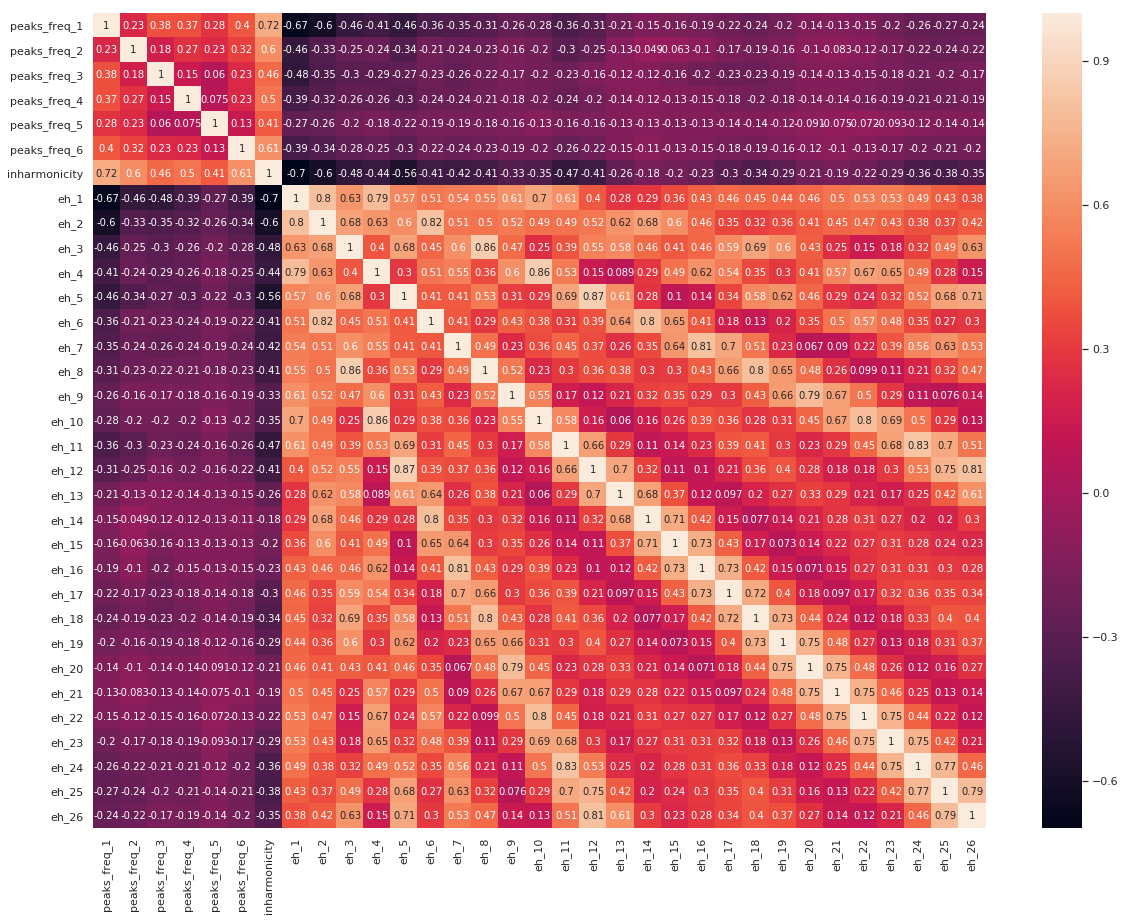



------------------------------------------------------------------------------------------------------------------------




In [10]:
if __name__ == "__main__" and '__file__' not in globals():
    correlation(merged_df)